# Libraries

In [3]:
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
#import joblib
#import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
#import pyarrow as pa
#import pyarrow.parquet as pq
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
#from sklearn.model_selection import StratifiedKFold
#import lightgbm as lgb
#from lightgbm import LGBMClassifier
from tqdm import tqdm

In [4]:
#Preprocessing by https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7963

# ====================================================
# Read & preprocess data and save it to disk
# ====================================================
def read_preprocess_data():
    train = pd.read_parquet(r'C:\Users\domin\Downloads\parq_data\train.parquet')
    features = train.drop(['customer_ID', 'S_2'], axis = 1).columns.to_list()
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    num_features = [col for col in features if col not in cat_features]
    print('Starting training feature engineer...')
    train_num_agg = train.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)
    train_cat_agg = train.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    train_labels = pd.read_csv(r'C:\Users\domin\Downloads\amex-default-prediction\train_labels.csv')
    train = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    del train_num_agg, train_cat_agg
    gc.collect()
    test = pd.read_parquet(r'C:\Users\domin\Downloads\parq_data\test.parquet')
    print('Starting test feature engineer...')
    test_num_agg = test.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)
    test_cat_agg = test.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
    test = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID')
    del test_num_agg, test_cat_agg
    gc.collect()
    # Save files to disk
    train.to_parquet(r'C:\Users\domin\Downloads\parq_data\train_fe.parquet')
    test.to_parquet(r'C:\Users\domin\Downloads\parq_data\test_fe.parquet')

In [ ]:
read_preprocess_data()

This method is not implemented well, there is not a big difference in memory

## Reduce RAM by changing float64 to float16 and pickling data

In [6]:
def reduce_memory_usage(df, chunk=None):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print("Initial Memory chunk: {:.3f}".format(start_mem))
    for col in df.columns:
        type_ = df[col].dtype
        if str(type_) != "object":
            if str(type_)[:3] == "int":
                df[col] = df[col].astype(np.int8)
            else:
                df[col] = df[col].astype(np.float16)
        else:
            df[col] = df[col].astype("category")   
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print("Final Memory chunk: {:.3f}".format(end_mem))
    print("Reduced by: {:.2f}".format((start_mem - end_mem) / start_mem))
    return df
chunksize=1.5*(10**5)
train_df = pd.DataFrame()
with pd.read_csv(r'C:\Users\domin\Downloads\amex-default-prediction\test_data.csv', chunksize=chunksize) as reader:
    counter=0
    for chunk in tqdm(reader):
        print(counter, flush=True)
        chunk=reduce_memory_usage(chunk)
        train_df = pd.concat([train_df, chunk])
        counter+=1
#labels=pd.read_csv(r'C:\Users\domin\Downloads\amex-default-prediction\train_labels.csv')
#labels=reduce_memory_usage(labels)
#train_df=pd.merge(train_df, labels, on='customer_ID')
train_df.to_pickle(r'C:\Users\domin\Downloads\AE_pickled\test.pkl')
del train_df
gc.collect()

0it [00:00, ?it/s]

0
Initial Memory chunk: 217.438


1it [00:13, 13.76s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
1
Initial Memory chunk: 217.438


2it [00:26, 13.30s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
2
Initial Memory chunk: 217.438


3it [00:39, 13.24s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
3
Initial Memory chunk: 217.438


4it [00:52, 12.99s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
4
Initial Memory chunk: 217.438


5it [01:04, 12.47s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
5
Initial Memory chunk: 217.438


6it [01:17, 12.73s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
6
Initial Memory chunk: 217.438


7it [01:28, 12.23s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
7
Initial Memory chunk: 217.438


8it [01:41, 12.37s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
8
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


9it [01:54, 12.65s/it]

9
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


10it [02:08, 13.07s/it]

10
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


11it [02:22, 13.32s/it]

11
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


12it [02:37, 13.81s/it]

12
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


13it [02:51, 14.00s/it]

13
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


14it [03:06, 14.22s/it]

14
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


15it [03:21, 14.43s/it]

15
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


16it [03:34, 14.05s/it]

16
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


17it [03:50, 14.58s/it]

17
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


18it [04:05, 14.85s/it]

18
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


19it [04:22, 15.45s/it]

19
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


20it [04:38, 15.42s/it]

20
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


21it [04:54, 15.64s/it]

21
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


22it [05:08, 15.32s/it]

22
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


23it [05:23, 15.22s/it]

23
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


24it [05:37, 14.88s/it]

24
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


25it [05:51, 14.51s/it]

25
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


26it [06:05, 14.30s/it]

26
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


27it [06:19, 14.16s/it]

27
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


28it [06:32, 13.82s/it]

28
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


29it [06:45, 13.55s/it]

29
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


30it [06:57, 13.32s/it]

30
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


31it [07:10, 13.19s/it]

31
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


32it [07:23, 13.10s/it]

32
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


33it [07:37, 13.26s/it]

33
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


34it [07:50, 13.27s/it]

34
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


35it [08:04, 13.54s/it]

35
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


36it [08:18, 13.60s/it]

36
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


37it [08:35, 14.60s/it]

37
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


38it [08:49, 14.35s/it]

38
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


39it [09:05, 15.02s/it]

39
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


40it [09:19, 14.59s/it]

40
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


41it [09:32, 14.22s/it]

41
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


42it [09:45, 13.95s/it]

42
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


43it [09:59, 13.77s/it]

43
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


44it [10:12, 13.66s/it]

44
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


45it [10:25, 13.54s/it]

45
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


46it [10:41, 14.23s/it]

46
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


47it [10:57, 14.54s/it]

47
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


48it [11:12, 14.86s/it]

48
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


49it [11:27, 14.70s/it]

49
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


50it [11:40, 14.48s/it]

50
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


51it [11:54, 14.24s/it]

51
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


52it [12:08, 14.21s/it]

52
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


53it [12:21, 13.80s/it]

53
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


54it [12:34, 13.44s/it]

54
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


55it [12:48, 13.61s/it]

55
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


56it [13:02, 13.76s/it]

56
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


57it [13:17, 14.31s/it]

57
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


58it [13:31, 14.06s/it]

58
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


59it [13:44, 13.85s/it]

59
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


60it [13:57, 13.57s/it]

60
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


61it [14:11, 13.61s/it]

61
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


62it [14:25, 13.80s/it]

62
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


63it [14:39, 13.83s/it]

63
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


64it [14:56, 14.87s/it]

64
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


65it [15:12, 15.05s/it]

65
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


66it [15:27, 14.97s/it]

66
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


67it [15:41, 14.89s/it]

67
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


68it [15:56, 14.71s/it]

68
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


69it [16:12, 15.25s/it]

69
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


70it [16:27, 15.06s/it]

70
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


71it [16:43, 15.40s/it]

71
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


72it [16:59, 15.66s/it]

72
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


73it [17:12, 14.93s/it]

73
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


74it [17:26, 14.62s/it]

74
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


75it [17:40, 14.40s/it]

75
Initial Memory chunk: 164.908
Final Memory chunk: 41.245
Reduced by: 0.75


76it [17:51, 14.10s/it]


0

In [5]:
df = pd.read_pickle(r'C:\Users\domin\Downloads\AE_pickled\train.pkl')

KeyboardInterrupt: 

In [ ]:
df

In [ ]:
df[df.columns[1:-1]]

This helps a lot! =)

# Data analysis

In [14]:
df = pd.read_pickle(r'C:\Users\domin\Downloads\AE_pickled\train.pkl')

## Categorical variables

### General remarks

In [15]:
def isNaN(num):
    return num != num
def completeness(col):
    return (len(col) -sum([1 for x in col if isNaN(x)]))/len(col)

In [16]:
def number_cat(list_of_categories):
    """Function to cast categorical vatriables as numeric, output - dictionary of mappings"""
    unique_values = list_of_categories.values.unique()
    corresponding_map = {}
    i = 0
    for q in unique_values:
        corresponding_map[q] = i
        i +=1
    return corresponding_map

In [17]:
cat_vars = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    'target'
    ]

In [18]:
df = df[cat_vars]
gc.collect()

341

In [19]:
mapping = number_cat(df['D_63'])
df['D_63'] = [mapping[q] for q in df['D_63']]
mapping = number_cat(df['D_64'])
df['D_64'] = [mapping[q] for q in df['D_64']]

In [20]:
#from matplotlib import pyplot as plt

In [21]:
#fig = plt.figure(figsize = (15,20))
#ax = fig.gca()
#df.hist(ax = ax, by = 'target')

In [22]:
for col in df.columns:
    print('Completeness of ' + str(col) +': ' + '{:.2%}'.format(completeness(df[col])))

Completeness of B_30: 99.96%
Completeness of B_38: 99.96%
Completeness of D_114: 96.81%
Completeness of D_116: 96.81%
Completeness of D_117: 96.81%
Completeness of D_120: 96.81%
Completeness of D_126: 97.89%
Completeness of D_63: 100.00%
Completeness of D_64: 100.00%
Completeness of D_66: 11.27%
Completeness of D_68: 96.09%
Completeness of target: 100.00%


### Correlations

In [23]:
df.corr().style.background_gradient(cmap='coolwarm')

Not big correleration overall, but its worth noting that B_38 and B_30 are strongly connected to our goal value.

### Histograms with target distribution

In [24]:
def generate_categorized_histogram(df, hist_col, category_column,  column_number):
    num_rows = int(len(hist_col)/3 + (len(hist_col) % 3 > 1))
    fig = make_subplots(rows = num_rows, cols = column_number, subplot_titles = hist_col)
    #fig = go.Figure()
    categories = df[category_column].unique()
    traces = []
    rn = cn = 1
    for col in hist_col:
        for cat in categories:   
            values = df[df[category_column] == cat]
            #temp = values[col].value_counts(dropna=False, normalize=True).sort_index().rename('count')
            temp = pd.DataFrame(values[col].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
            temp.index.name = 'value'
            temp.reset_index(inplace=True)
            fig.append_trace(go.Bar(
            y=temp['count'],
            x=temp.index,
            name= col + ', target: ' + str(cat)
            ),rn,cn)
        #if we hit the line limit for plots
        if cn + 1 > column_number:
            rn +=1
            cn = 1
        else:
            cn +=1
    
    fig.update_layout(barmode='group', title = 'Distribution of categorical values grouped by target value.',
                     showlegend=False, height=800, width=950)
    return fig

In [25]:
generate_categorized_histogram(df,cat_vars[:-1] , 'target', 3).show()

In [27]:
df = pd.read_pickle(r'C:\Users\domin\Downloads\AE_pickled\train.pkl')
cat_vars = ['customer_ID',
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    'target'
    ]
mapping = number_cat(df['D_63'])
df['D_63'] = [mapping[q] for q in df['D_63']]
mapping = number_cat(df['D_64'])
df['D_64'] = [mapping[q] for q in df['D_64']]
df

customer_ID         S_2       P_2      D_39       B_1       B_2       R_1       S_3      D_41       B_3  D_42      D_43      D_44       B_4      D_45       B_5       R_2      D_46      D_47      D_48  D_49       B_6       B_7       B_8      D_50      D_51       B_9       R_3      D_52       P_3      B_10  D_53       S_5      B_11       S_6      D_54       R_4       S_7      B_12       S_8      D_55      D_56      B_13       R_5      D_58       S_9      B_14      D_59      D_60      D_61      B_15      S_11      D_62  D_63  D_64      D_65      B_16      B_17      B_18      B_19  D_66      B_20  D_68      S_12       R_6      S_13      B_21      D_69      B_22      D_70      D_71      D_72      S_15      B_23  D_73       P_4      D_74      D_75  D_76      B_24       R_7      D_77      B_25      B_26      D_78      D_79       R_8  R_9      S_16      D_80      R_10      R_11      B_27      D_81      D_82      S_17      R_12      B_28  \
0        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09  0.938477  0.001734  0.008728  1.006836  0.009224  0.124023  0.008774  0.004707   NaN       NaN  0.000630  0.080994  0.708984  0.170654  0.006203  0.358643  0.525391  0.255615   NaN  0.063904  0.059418  0.006466  0.148682  1.335938  0.008209  0.001423  0.207275  0.736328  0.096191   NaN  0.023376  0.002768  0.008324  1.001953  0.008301  0.161377  0.148315  0.922852  0.354492  0.151978  0.118103  0.001882  0.158569  0.065735  0.018387  0.063660  0.199585  0.308350  0.016357  0.401611  0.091064     0     0  0.007126  0.007664       NaN  0.652832  0.008522   NaN  0.004730   6.0  0.271973  0.008362  0.515137  0.002644  0.009010  0.004807  0.008339  0.119385  0.004803  0.108276  0.050873   NaN  0.007553  0.080444  0.069092   NaN  0.004326  0.007561       NaN  0.007729  0.000272  0.001575  0.004238  0.001434  NaN  0.002272  0.004059  0.007122  0.002457  0.002310  0.003532  0.506836  0.008034  1.009766  0.084656   
1        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07  0.936523  0.005775  0.004925  1.000977  0.006153  0.126709  0.000798  0.002714   NaN       NaN  0.002525  0.069397  0.712891  0.113220  0.006207  0.353516  0.521484  0.223389   NaN  0.065247  0.057739  0.001614  0.149780  1.339844  0.008369  0.001984  0.202759  0.720703  0.099792   NaN  0.030594  0.002748  0.002481  1.008789  0.005135  0.140991  0.143555  0.919434  0.326660  0.156250  0.118713  0.001610  0.148438  0.093933  0.013039  0.065491  0.151367  0.265137  0.017685  0.406250  0.086792     0     0  0.002413  0.007149       NaN  0.646973  0.002237   NaN  0.003880   6.0  0.188965  0.004028  0.509277  0.004192  0.007843  0.001283  0.006523  0.140625  0.000094  0.101013  0.040466   NaN  0.004833  0.081421  0.074158   NaN  0.004204  0.005302       NaN  0.001864  0.000978  0.009895  0.007599  0.000509  NaN  0.009811  0.000126  0.005966  0.000395  0.001327  0.007774  0.500977  0.000761  1.009766  0.081848   
2        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28  0.954102  0.091492  0.021652  1.009766  0.006817  0.123962  0.007599  0.009422   NaN       NaN  0.007607  0.068848  0.720703  0.060486  0.003260  0.334717  0.524414  0.189453   NaN  0.066956  0.056641  0.005127  0.151978  1.336914  0.009354  0.007427  0.206665  0.738281  0.134033   NaN  0.048370  0.010078  0.000530  1.008789  0.006962  0.112244  0.136963  1.001953  0.304199  0.153809  0.114563  0.006329  0.139526  0.084778  0.056641  0.070618  0.305908  0.212158  0.063965  0.406738  0.093994     0     0  0.001878  0.003637       NaN  0.645996  0.000408   NaN  0.004578   6.0  0.495361  0.006840  0.679199  0.001336  0.006023  0.009392  0.002615  0.075867  0.007153  0.103210  0.047455   NaN  0.006561  0.078918  0.076538   NaN  0.001782  0.001422       NaN  0.005417  0.006149  0.009628  0.003094  0.008293  NaN  0.009361  0.000954  0.005447  0.007347  0.007626  0.008812  0.504395  0.004055  1.003906  0.081970   
3        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13  0.9

In [30]:
test_cat_agg = df.groupby("customer_ID")[cat_vars[1:]].agg(['count', 'last', 'nunique'])
test_cat_agg

B_30               B_38              D_114              D_116              D_117              D_120              D_126               D_63               D_64               D_66               D_68              target             
                                                   count last nunique count last nunique count last nunique count last nunique count last nunique count last nunique count last nunique count last nunique count last nunique count last nunique count last nunique  count last nunique
customer_ID                                                                                                                                                                                                                                                                            
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...    13  0.0       1    13  2.0       1    13  1.0       1    13  0.0       1    13  4.0       1    13  0.0       1    13  1.0       1    13    0       1    13    0       1     0  NaN       0    13  6.0       1     13    0       1
00000fd6641609c6ece5454664794f0340ad84dddce9a26...    13  0.0       1    13  2.0       1    13  1.0       1    13  0.0       1    13 -1.0       1    13  0.0       2    13  1.0       1    13    1       1    13    0       1     0  NaN       0    13  6.0       1     13    0       1
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...    13  0.0       1    13  1.0       1    13  1.0       2    13  0.0       1    13 -1.0       1    13  0.0       1    13  1.0       1    13    1       1    13    1       1     0  NaN       0    13  6.0       1     13    0       1
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...    13  0.0       1    13  2.0       1    13  1.0       1    13  0.0       1    13  6.0       2    13  0.0       1    13  1.0       1    13    1       1    13    0       1     0  NaN       0    13  3.0       3     13    0       1
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...    13  0.0       1    13  1.0       2    13  1.0       1    13  0.0       1    13  4.0       1    13  0.0       1    13  1.0       1    13    1       1    13    0       1    13  1.0       1    13  6.0       1     13    0       1
...                                                  ...  ...     ...   ...  ...     ...   ...  ...     ...   ...  ...     ...   ...  ...     ...   ...  ...     ...   ...  ...     ...   ...  ...     ...   ...  ...     ...   ...  ...     ...   ...  ...     ...    ...  ...     ...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a40...    13  0.0       1    13  2.0       1    13  0.0       1    13  0.0       1    13  3.0       2    13  1.0       2    13  1.0       1    13    1       1    13    3       1    13  1.0       1    13  6.0       1     13    0       1
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd...    13  0.0       2    13  7.0       2    13  1.0       1    13  0.0       1    13  2.0       2    13  0.0       1    13  1.0       1    13    1       1    13    1       1     0  NaN       0    13  6.0       1     13    0       1
ffff9984b999fccb2b6127635ed0736dda94e544e67e026...    13  0.0       1    13  3.0       2    13  1.0       1    13  0.0       1    13 -1.0       1    13  0.0       1    13  1.0       1    13    1       1    13    3       1     0  NaN       0    13  5.0       1     13    0       1
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...    13  0.0       1    13  3.0       1    13  1.0       2    13  0.0       1    13  2.0       2    13  0.0       1    13  1.0       1    13    1       1    13    3       2     0  NaN       0    13  3.0       2     13    1       1
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...    13  0.0       1    13  3.0       1    13  1.0       1    13  0.0       1    13  3.0       1    13  0.0       1    13  1.0       1    13    2       1    13    0       2     0  NaN       0    13  5.0       2     13    0       1

[458913 rows x 36 columns]

For most of variables we can see significant differences between groups with traget == 0 and target == 1, which combined with high completeness of this variables may indicate that they will be usefull in modelling.

### Dumb tree for component analysis

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [14]:
clean_cols = ['B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68', 'target']
to_train = df[clean_cols].dropna()
to_train.shape

(5308703, 11)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(to_train[clean_cols[:-1]].values,to_train[clean_cols[-1]].values,
                                                    stratify=to_train[clean_cols[-1]].values, random_state = 42)
print('Train data shape: ' + str(X_train.shape)) 
print('Test data shape: ' + str(X_test.shape)) 

Train data shape: (3981527, 10)
Test data shape: (1327176, 10)


In [16]:
tree= DecisionTreeClassifier(max_depth = 20, min_samples_leaf = 1, min_samples_split = 2)
tree.fit(X_train, y_train)
print('Dumb tree dumb score  on training data: ' + '{:.2%}'.format(tree.score(X_train,y_train)))
print('Dumb tree dumb score  on test data: ' + '{:.2%}'.format(tree.score(X_test,y_test)))

Dumb tree dumb score  on training data: 82.34%
Dumb tree dumb score  on test data: 81.85%


In [18]:
tree.predict(X_test)

array([1, 0, 1, ..., 1, 1, 0], dtype=int8)

In [26]:
amex_metric_mod(y_test, tree.predict(X_test))

0.13946194856762237

In [77]:
params = {'min_samples_leaf' : [1, 10, 20] , 'min_samples_split' : [2, 8, 20], 'max_depth' :[4, 6, 8, 20]} 

In [78]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(), params, cv = 5)
grid_search.fit(X_train, y_train)
print('Best params: {}'.format(grid_search.best_params_))
print('Best score: {:2f}'.format(grid_search.best_score_))

Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.817850


In [ ]:
print('Best params: {}'.format(grid_search.best_params_))
print('Best score: {:2f}'.format(grid_search.best_score_))

In [20]:
def feature_importance(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align = 'center')
    plt.yticks(np.arange(n_features), clean_cols[:-1])
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

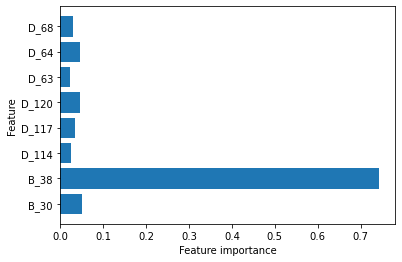

In [28]:
feature_importance(tree)

In [27]:
clean_cols = ['B_38', 'D_114', 'D_117', 'D_120', 'D_63', 'D_64', 'D_68', 'target']
to_train = df[clean_cols].dropna()
to_train.shape
X_train, X_test, y_train, y_test = train_test_split(to_train[clean_cols[:-1]].values,to_train[clean_cols[-1]].values,
                                                    stratify=to_train[clean_cols[-1]].values, random_state = 42)
print('Train data shape: ' + str(X_train.shape)) 
print('Test data shape: ' + str(X_test.shape)) 
tree= DecisionTreeClassifier(max_depth = 20, min_samples_leaf = 1, min_samples_split = 2)
tree.fit(X_train, y_train)
print('Dumb tree dumb score  on training data: ' + '{:.2%}'.format(tree.score(X_train,y_train)))
print('Dumb tree dumb score  on test data: ' + '{:.2%}'.format(tree.score(X_test,y_test)))

Train data shape: (3981527, 8)
Test data shape: (1327176, 8)
Dumb tree dumb score  on training data: 82.02%
Dumb tree dumb score  on test data: 81.72%


##  All features

In [4]:
df = pd.read_pickle(r'C:\Users\domin\Downloads\AE_pickled\train.pkl')

In [5]:
df.shape

(5531451, 191)

### Correlations within the data

In [6]:
cors = df.corr().style.background_gradient(cmap='coolwarm')
cors

In [8]:
cors = df.corr()

In [9]:
noticible_corrs = {}
for col, row in enumerate(cors.index):
    for i in range(col):
        cor =  abs(cors.loc[row, cors.columns[i]])
        if (cor >= 0.7) & (row != cors.columns[i]):
            noticible_corrs[row] = {'with' : cors.columns[i], 'value' : round(cor,4)}
correlations = pd.DataFrame({'Feature' : noticible_corrs.keys(),
                             '2nd_feature': [noticible_corrs[key]['with'] for key in noticible_corrs.keys()],
                            'Absolute correlation' : [noticible_corrs[key]['value'] for key in noticible_corrs.keys()]})

In [10]:
correlations.sort_values(by = 'Absolute correlation', ascending = False).reset_index(drop = True)

Feature 2nd_feature  Absolute correlation
0     D_77        D_62                0.9998
1    D_104       D_103                0.9997
2    D_141       D_139                0.9982
3    D_143       D_141                0.9977
4     B_23         B_7                0.9951
5    D_119       D_118                0.9949
6     D_75        D_74                0.9876
7     S_24        S_22                0.9593
8     D_74        D_58                0.9226
9     B_15        B_14                0.9099
10     S_7         S_3                0.9046
11   D_132       D_131                0.8800
12   D_131        D_79                0.8721
13    D_55        D_48                0.8617
14   D_107       D_104                0.8434
15    D_61        D_48                0.8266
16   D_118       D_115                0.8250
17    B_13        B_12                0.8209
18     R_8         R_5                0.7915
19    B_19         B_3                0.7893
20    S_15         S_8                0.7869
21    B_18        B_16                0.7822
22   D_142       D_141                0.7793
23     R_4         R_2                0.7783
24    R_21        S_20                0.7743
25    B_30        B_22                0.7691
26    B_33        B_20                0.7654
27    D_48         P_2                0.7601
28    B_22         B_3                0.7504
29    B_20        B_18                0.7474
30   D_129       D_128                0.7471
31   D_105       D_104                0.7429
32    D_58        D_55                0.7358
33     B_8        D_45                0.7332
34   D_103       D_102                0.7313
35    D_84        D_53                0.7304
36   D_133       D_131                0.7291
37    B_16         B_3                0.7241
38    B_42        D_76                0.7211
39    B_37        B_19                0.7200
40    B_11         B_3                0.7182
41   D_113        D_68                0.7169
42    D_81        D_53                0.7152
43     B_3         B_2                0.7135
44    B_28        B_14                0.7059
45   D_121        D_47                0.7048
46    B_38        B_19                0.7038

In [11]:
cors['target'].sort_values()

P_2      -0.610765
B_18     -0.487393
B_2      -0.483062
B_33     -0.452972
D_62     -0.352230
D_77     -0.335407
D_47     -0.280047
R_27     -0.277071
D_45     -0.270544
D_51     -0.249153
S_25     -0.246599
P_3      -0.243743
D_52     -0.225860
D_112    -0.216717
D_128    -0.188602
D_114    -0.188517
D_127    -0.180839
D_115    -0.177609
D_68     -0.175395
D_118    -0.170255
D_121    -0.169109
D_119    -0.168585
D_122    -0.156961
S_8      -0.154099
D_92     -0.147674
D_56     -0.146568
D_54     -0.137840
D_129    -0.135701
R_12     -0.135399
D_76     -0.122359
D_91     -0.121290
B_42     -0.117707
D_117    -0.110870
S_13     -0.106136
D_73     -0.103579
D_132    -0.100325
S_6      -0.098949
B_39     -0.093300
S_11     -0.085390
D_71     -0.080374
D_60     -0.076489
D_94     -0.068738
D_86     -0.067228
B_5      -0.065265
D_50     -0.060723
B_31     -0.060364
D_142    -0.060227
D_96     -0.060198
D_66     -0.051476
S_26     -0.042265
B_6      -0.039858
D_105    -0.037010
D_93     -0.

In [12]:
occurances = list(correlations['Feature']) + (list(correlations['2nd_feature']))

In [13]:
for q in list(set(occurances)): print(q + ' occured ' + str(occurances.count(q)) + ' times.')
del noticible_corrs, correlations, occurances, cors
gc.collect()

D_105 occured 1 times.
R_21 occured 1 times.
B_15 occured 1 times.
D_142 occured 1 times.
B_30 occured 1 times.
B_3 occured 5 times.
D_58 occured 2 times.
D_132 occured 1 times.
D_79 occured 1 times.
B_7 occured 1 times.
D_102 occured 1 times.
B_16 occured 2 times.
B_19 occured 3 times.
D_129 occured 1 times.
R_5 occured 1 times.
D_139 occured 1 times.
D_118 occured 2 times.
D_104 occured 3 times.
D_55 occured 2 times.
S_15 occured 1 times.
B_28 occured 1 times.
D_133 occured 1 times.
D_74 occured 2 times.
D_143 occured 1 times.
B_13 occured 1 times.
P_2 occured 1 times.
R_2 occured 1 times.
S_3 occured 1 times.
S_20 occured 1 times.
D_115 occured 1 times.
D_45 occured 1 times.
D_77 occured 1 times.
B_2 occured 1 times.
R_4 occured 1 times.
B_33 occured 1 times.
R_8 occured 1 times.
D_103 occured 2 times.
D_62 occured 1 times.
D_113 occured 1 times.
D_84 occured 1 times.
B_42 occured 1 times.
D_48 occured 3 times.
D_76 occured 1 times.
B_14 occured 2 times.
S_24 occured 1 times.
B_12 o

334

In [22]:
print('Unique customers in dataset: ' + "{:,}".format(len(df['customer_ID'].unique())).replace(",", " "))
print('Average entries per customer: ' + str(round(np.mean(df[['customer_ID', 'S_2']].groupby(by = 'customer_ID').count())[0],2)))
print('Median entries per customer: ' + str(round(np.median(df[['customer_ID', 'S_2']].groupby(by = 'customer_ID').count()),2)))
print('Amount of continous variables: ' + str(len(df.columns) - len(categorical_variables)))
print('Amount of categorical variables: ' + str(len(categorical_variables)))

Unique customers in dataset: 458 913
Average entries per customer: 12.05
Median entries per customer: 13.0
Amount of continous variables: 180
Amount of categorical variables: 11


In [24]:
entries = {}
for col in df.columns[1:]:
    entries[col] = round(np.mean(df[['customer_ID', col]].groupby(by = 'customer_ID').count())[0],2)
for q in entries.keys:
print(q +' : ' + str(entries[q]))

{'S_2': 12.05, 'P_2': 11.95, 'D_39': 12.05, 'B_1': 12.05, 'B_2': 12.05, 'R_1': 12.05, 'S_3': 9.83, 'D_41': 12.05, 'B_3': 12.05, 'D_42': 1.72, 'D_43': 8.44, 'D_44': 11.46, 'B_4': 12.05, 'D_45': 12.05, 'B_5': 12.05, 'R_2': 12.05, 'D_46': 9.41, 'D_47': 12.05, 'D_48': 10.49, 'D_49': 1.19, 'B_6': 12.05, 'B_7': 12.05, 'B_8': 12.0, 'D_50': 5.21, 'D_51': 12.05, 'B_9': 12.05, 'R_3': 12.05, 'D_52': 11.99, 'P_3': 11.4, 'B_10': 12.05, 'D_53': 3.15, 'S_5': 12.05, 'B_11': 12.05, 'S_6': 12.05, 'D_54': 12.05, 'R_4': 12.05, 'S_7': 9.83, 'B_12': 12.05, 'S_8': 12.05, 'D_55': 11.65, 'D_56': 5.54, 'B_13': 11.95, 'R_5': 12.05, 'D_58': 12.05, 'S_9': 5.66, 'B_14': 12.05, 'D_59': 11.82, 'D_60': 12.05, 'D_61': 10.75, 'B_15': 12.04, 'S_11': 12.05, 'D_62': 10.4, 'D_63': 12.05, 'D_64': 11.58, 'D_65': 12.05, 'B_16': 12.05, 'B_17': 5.22, 'B_18': 12.05, 'B_19': 12.05, 'D_66': 1.36, 'B_20': 12.05, 'D_68': 11.58, 'S_12': 12.05, 'R_6': 12.05, 'S_13': 12.05, 'B_21': 12.05, 'D_69': 11.63, 'B_22': 12.05, 'D_70': 11.85, 'D_

In [27]:
for q in entries.keys():
    print(q +' : ' + str(entries[q]))

S_2 : 12.05
P_2 : 11.95
D_39 : 12.05
B_1 : 12.05
B_2 : 12.05
R_1 : 12.05
S_3 : 9.83
D_41 : 12.05
B_3 : 12.05
D_42 : 1.72
D_43 : 8.44
D_44 : 11.46
B_4 : 12.05
D_45 : 12.05
B_5 : 12.05
R_2 : 12.05
D_46 : 9.41
D_47 : 12.05
D_48 : 10.49
D_49 : 1.19
B_6 : 12.05
B_7 : 12.05
B_8 : 12.0
D_50 : 5.21
D_51 : 12.05
B_9 : 12.05
R_3 : 12.05
D_52 : 11.99
P_3 : 11.4
B_10 : 12.05
D_53 : 3.15
S_5 : 12.05
B_11 : 12.05
S_6 : 12.05
D_54 : 12.05
R_4 : 12.05
S_7 : 9.83
B_12 : 12.05
S_8 : 12.05
D_55 : 11.65
D_56 : 5.54
B_13 : 11.95
R_5 : 12.05
D_58 : 12.05
S_9 : 5.66
B_14 : 12.05
D_59 : 11.82
D_60 : 12.05
D_61 : 10.75
B_15 : 12.04
S_11 : 12.05
D_62 : 10.4
D_63 : 12.05
D_64 : 11.58
D_65 : 12.05
B_16 : 12.05
B_17 : 5.22
B_18 : 12.05
B_19 : 12.05
D_66 : 1.36
B_20 : 12.05
D_68 : 11.58
S_12 : 12.05
R_6 : 12.05
S_13 : 12.05
B_21 : 12.05
D_69 : 11.63
B_22 : 12.05
D_70 : 11.85
D_71 : 12.05
D_72 : 12.0
S_15 : 12.05
B_23 : 12.05
D_73 : 0.12
P_4 : 12.05
D_74 : 12.01
D_75 : 12.05
D_76 : 1.36
B_24 : 12.05
R_7 : 12.05
D_77

Most frequently we have 12 datapoints per user, taking in to consideration the duration of data collection, it may lead to creating features based on some window selection. As for general rule I will start by adding aggregated features on customer level.

### Completeness

In [11]:
comp = {}
for col in df.columns:
    #comp.append(completeness(df[col]))
    comp[col] =completeness(df[col]) 
    #print('Completeness of ' + str(col) +': ' + '{:.2%}'.format(completeness(df[col])))
comp = {k: v for k, v in sorted(comp.items(), key=lambda item: item[1])}
comp

{'D_87': 0.000698731670948545,
 'D_88': 0.0010854294831500813,
 'D_108': 0.005231538704763,
 'D_110': 0.005664698105433818,
 'D_111': 0.005664698105433818,
 'B_39': 0.006080140635793393,
 'D_73': 0.01009789293984526,
 'B_42': 0.012922106694970271,
 'D_134': 0.03519854012988635,
 'D_135': 0.03519854012988635,
 'D_136': 0.03519854012988635,
 'D_137': 0.03519854012988635,
 'D_138': 0.03519854012988635,
 'R_9': 0.05650108805085682,
 'B_29': 0.06895405925136099,
 'D_106': 0.09786744924613813,
 'D_132': 0.09808945247820147,
 'D_49': 0.09862403192218461,
 'R_26': 0.11015283331624921,
 'D_76': 0.11253774100141174,
 'D_66': 0.11269267322443967,
 'D_42': 0.1430572195252204,
 'D_142': 0.17073422507042005,
 'D_53': 0.26157078856885835,
 'D_82': 0.2662659399857289,
 'D_50': 0.4319027683694568,
 'B_17': 0.4327712565834896,
 'D_105': 0.453772436924778,
 'D_56': 0.4592841914354841,
 'S_9': 0.4696431370358338,
 'D_77': 0.5455239502257183,
 'D_43': 0.7001878892174946,
 'S_27': 0.7467328192909961,
 'D_46

In [12]:
to_del = [       "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_66",
        "D_68"]
for q in to_del: del comp[q]

In [13]:
for key in comp.copy().keys():
    if comp[key] == 1: 
        del comp[key]
comp

{'D_87': 0.000698731670948545,
 'D_88': 0.0010854294831500813,
 'D_108': 0.005231538704763,
 'D_110': 0.005664698105433818,
 'D_111': 0.005664698105433818,
 'B_39': 0.006080140635793393,
 'D_73': 0.01009789293984526,
 'B_42': 0.012922106694970271,
 'D_134': 0.03519854012988635,
 'D_135': 0.03519854012988635,
 'D_136': 0.03519854012988635,
 'D_137': 0.03519854012988635,
 'D_138': 0.03519854012988635,
 'R_9': 0.05650108805085682,
 'B_29': 0.06895405925136099,
 'D_106': 0.09786744924613813,
 'D_132': 0.09808945247820147,
 'D_49': 0.09862403192218461,
 'R_26': 0.11015283331624921,
 'D_76': 0.11253774100141174,
 'D_42': 0.1430572195252204,
 'D_142': 0.17073422507042005,
 'D_53': 0.26157078856885835,
 'D_82': 0.2662659399857289,
 'D_50': 0.4319027683694568,
 'B_17': 0.4327712565834896,
 'D_105': 0.453772436924778,
 'D_56': 0.4592841914354841,
 'S_9': 0.4696431370358338,
 'D_77': 0.5455239502257183,
 'D_43': 0.7001878892174946,
 'S_27': 0.7467328192909961,
 'D_46': 0.7809437342932262,
 'S_3':

In [21]:
def target_based_inputation(df, col_name, target_col, shady = 0):
    """Function inputs mean for different target groups"""
    if shady:
        mean0 = round(np.nanmean(df[df[target_col] == 0][col_name].astype('float64')),4)
        mean1 = round(np.nanmean(df[df[target_col] == 1][col_name].astype('float64')),4) 
        work_list = [a*b for a,b in zip(df[col_name], df[target_col])]
        work_list = [x if not isNaN(x) else mean1 if x > 0 else mean0 for x in work_list]
    else:
        mean = round(np.nanmean(df[col_name].astype('float64')),4) 
        work_list = [x if not isNaN(x) else mean for x in df[col_name]]        
    return work_list

In [16]:
# Removing some of least populated columns for now
least_populated = [
'D_87','D_88','D_108','D_110','D_111','B_39','D_73','B_42','D_134','D_135'
,'D_136','D_137','D_138','R_9','B_29','D_106','D_132','D_49','R_26','D_76','D_66','D_42','D_142','D_53','D_82']

In [17]:
list(comp.keys())[17]

'D_49'

In [18]:
for q in least_populated:
    if q in comp.keys():
        del comp[q]
print('Before trimming : '+ str(df.shape))
df = df[[x for x in df.columns if x not in least_populated]]
print('After trimming : '+ str(df.shape))

Before trimming : (5531451, 191)
After trimming : (5531451, 166)


In [19]:
df.dropna().shape

(97534, 166)

In [22]:
for col in tqdm(comp.keys()):
    df[col] = target_based_inputation(df, col, 'target')

100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [03:12<00:00,  2.19s/it]


In [23]:
df.dropna().shape

(5308703, 166)

In [24]:
df.to_pickle('phase_1_1.pkl')

#### Categorical variables completeness

In [19]:
categorical_variables = [x for x in cat_vars]
categorical_variables

['B_30',
 'B_38',
 'D_114',
 'D_116',
 'D_117',
 'D_120',
 'D_126',
 'D_63',
 'D_64',
 'D_66',
 'D_68']

b_30 

array([[<AxesSubplot:title={'center':'B_30'}>,
        <AxesSubplot:title={'center':'B_38'}>,
        <AxesSubplot:title={'center':'D_114'}>],
       [<AxesSubplot:title={'center':'D_116'}>,
        <AxesSubplot:title={'center':'D_117'}>,
        <AxesSubplot:title={'center':'D_120'}>],
       [<AxesSubplot:title={'center':'D_126'}>,
        <AxesSubplot:title={'center':'D_63'}>,
        <AxesSubplot:title={'center':'D_64'}>],
       [<AxesSubplot:title={'center':'D_68'}>,
        <AxesSubplot:title={'center':'target'}>, <AxesSubplot:>]],
      dtype=object)

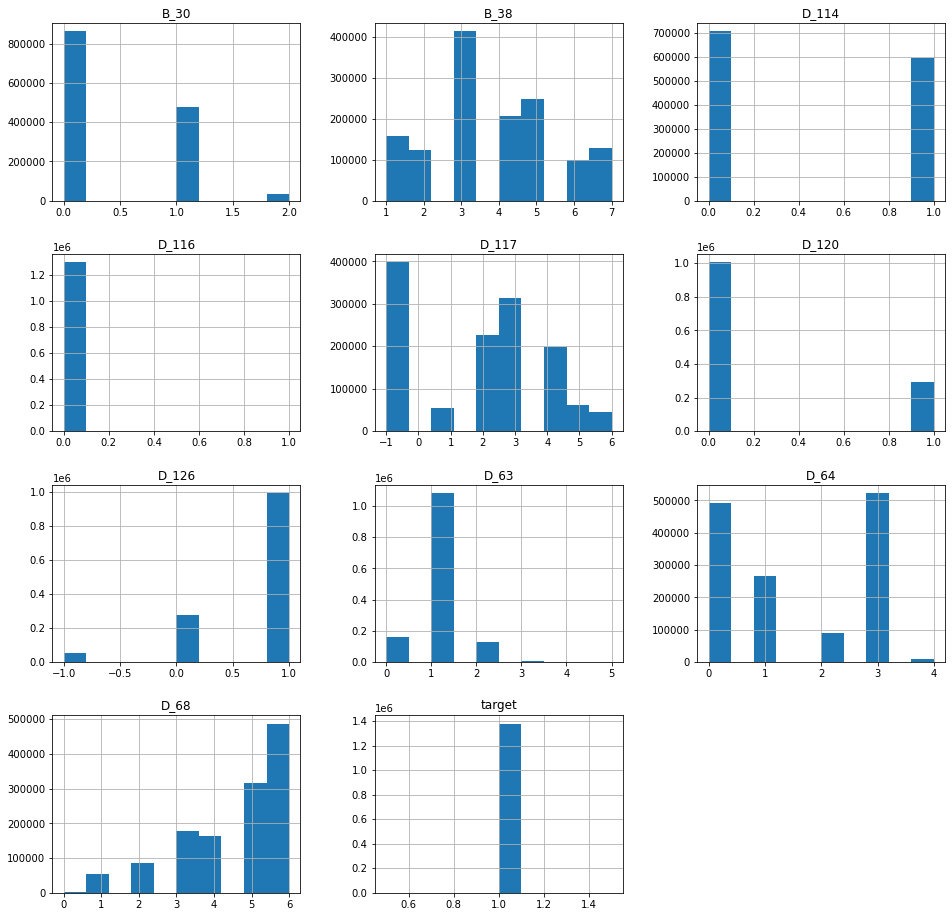

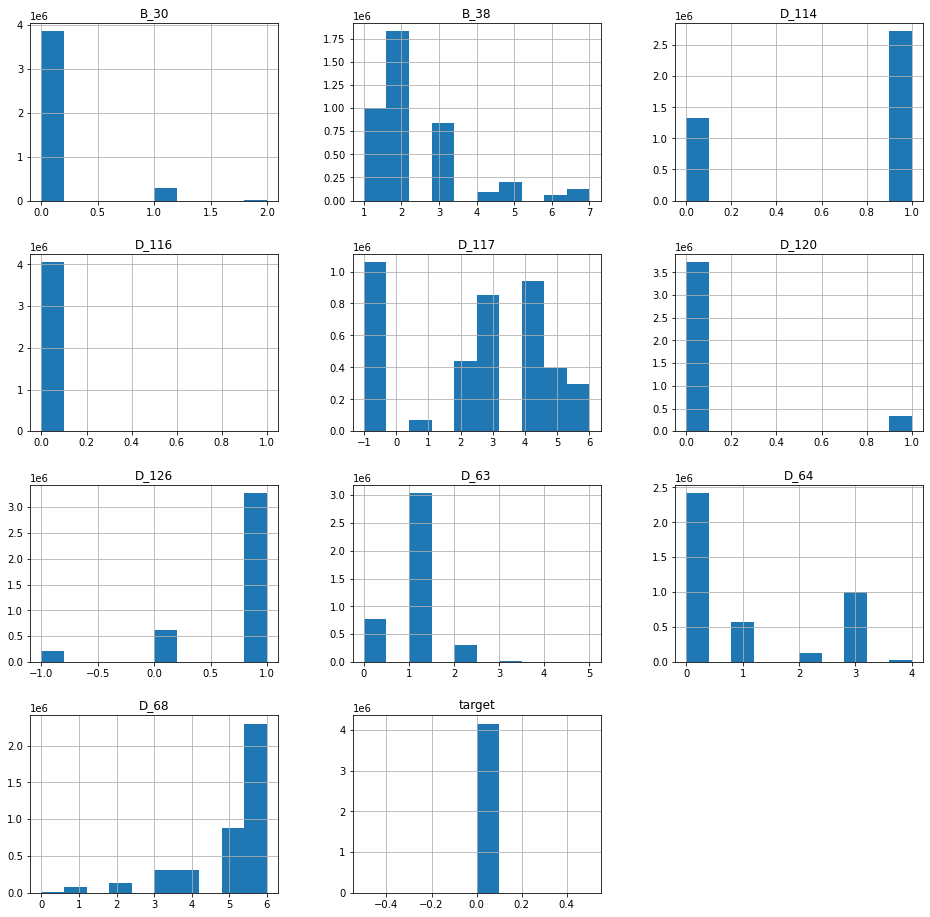

In [38]:
df[df['target'] == 1][categorical_variables].hist(figsize = (16,16))
df[df['target'] == 0][categorical_variables].hist(figsize = (16,16))

In [18]:
df.to_pickle('phase_1.pkl')

In [19]:
comp = {}
for col in df.columns:
    #comp.append(completeness(df[col]))
    comp[col] =completeness(df[col]) 
    #print('Completeness of ' + str(col) +': ' + '{:.2%}'.format(completeness(df[col])))
comp = {k: v for k, v in sorted(comp.items(), key=lambda item: item[1])}
comp

{'D_68': 0.9608596370102528,
 'D_114': 0.9680525055722269,
 'D_116': 0.9680525055722269,
 'D_117': 0.9680525055722269,
 'D_120': 0.9680525055722269,
 'D_126': 0.9788814905889973,
 'B_30': 0.999635538667883,
 'B_38': 0.999635538667883,
 'customer_ID': 1.0,
 'S_2': 1.0,
 'P_2': 1.0,
 'D_39': 1.0,
 'B_1': 1.0,
 'B_2': 1.0,
 'R_1': 1.0,
 'S_3': 1.0,
 'D_41': 1.0,
 'B_3': 1.0,
 'D_43': 1.0,
 'D_44': 1.0,
 'B_4': 1.0,
 'D_45': 1.0,
 'B_5': 1.0,
 'R_2': 1.0,
 'D_46': 1.0,
 'D_47': 1.0,
 'D_48': 1.0,
 'B_6': 1.0,
 'B_7': 1.0,
 'B_8': 1.0,
 'D_50': 1.0,
 'D_51': 1.0,
 'B_9': 1.0,
 'R_3': 1.0,
 'D_52': 1.0,
 'P_3': 1.0,
 'B_10': 1.0,
 'S_5': 1.0,
 'B_11': 1.0,
 'S_6': 1.0,
 'D_54': 1.0,
 'R_4': 1.0,
 'S_7': 1.0,
 'B_12': 1.0,
 'S_8': 1.0,
 'D_55': 1.0,
 'D_56': 1.0,
 'B_13': 1.0,
 'R_5': 1.0,
 'D_58': 1.0,
 'S_9': 1.0,
 'B_14': 1.0,
 'D_59': 1.0,
 'D_60': 1.0,
 'D_61': 1.0,
 'B_15': 1.0,
 'S_11': 1.0,
 'D_62': 1.0,
 'D_63': 1.0,
 'D_64': 1.0,
 'D_65': 1.0,
 'B_16': 1.0,
 'B_17': 1.0,
 'B_18': 1.

## Continous variable analysis

In [15]:
continous_variables = [x for x in df.columns if x not in categorical_variables[:-1]]

NameError: name 'categorical_variables' is not defined

In [7]:
plot_df = df[continous_variables[2:]]

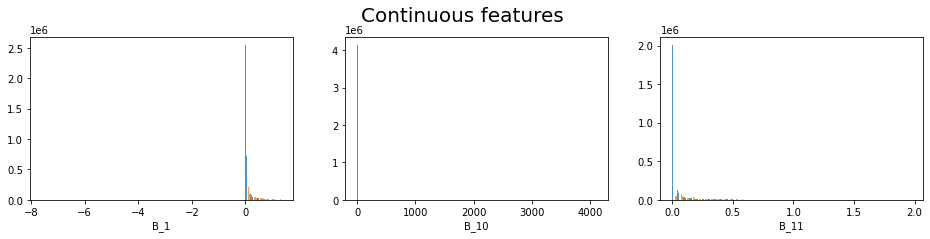

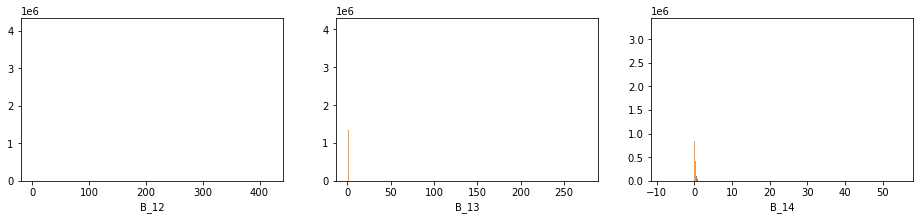

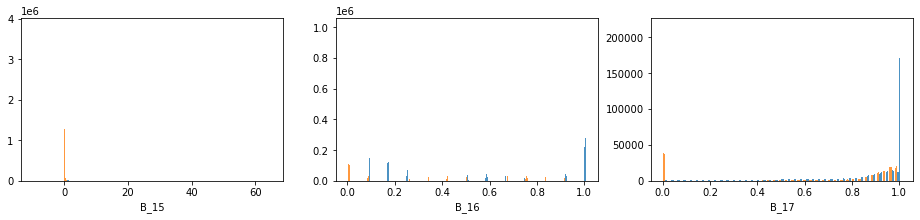

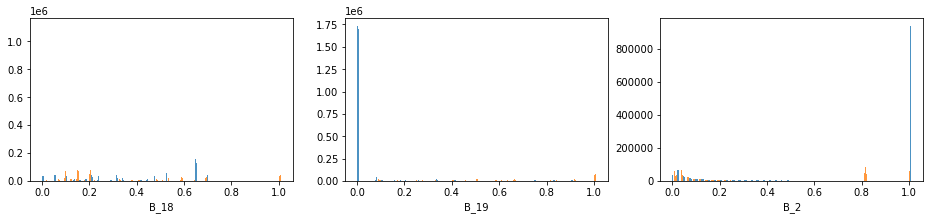

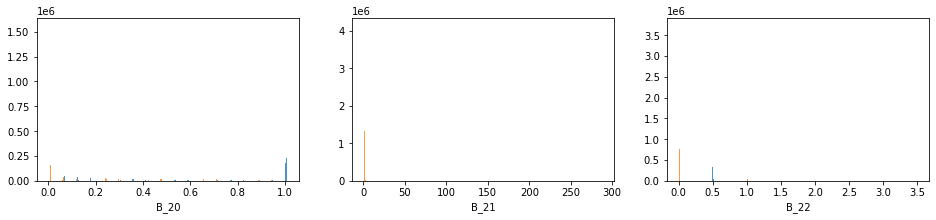

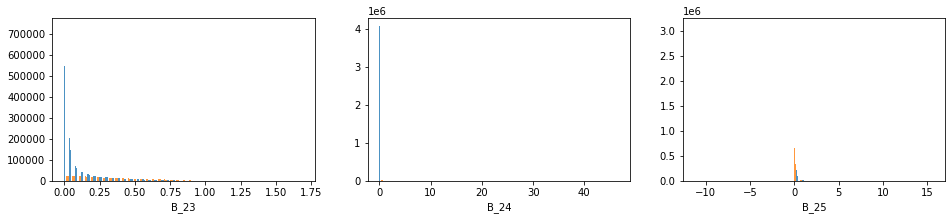

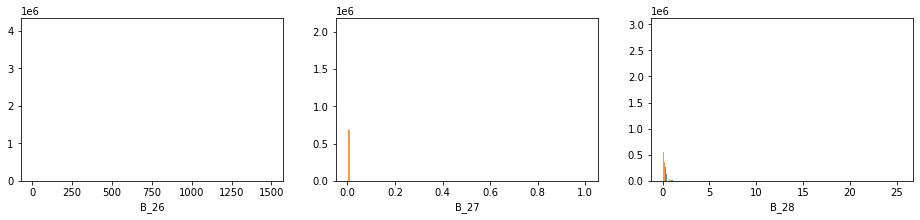

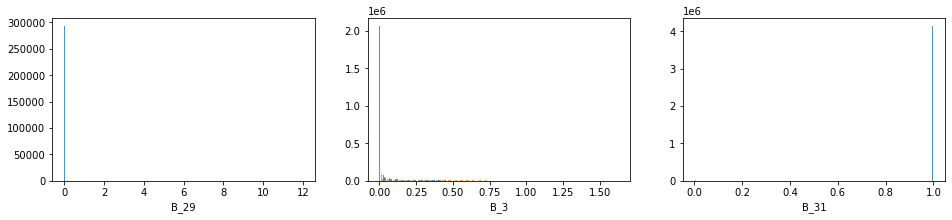

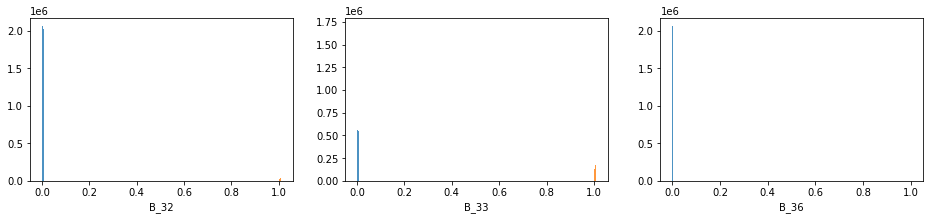

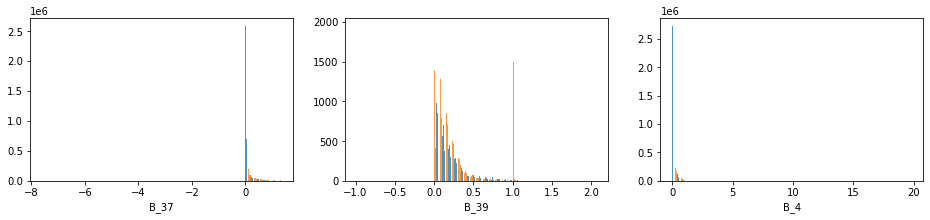

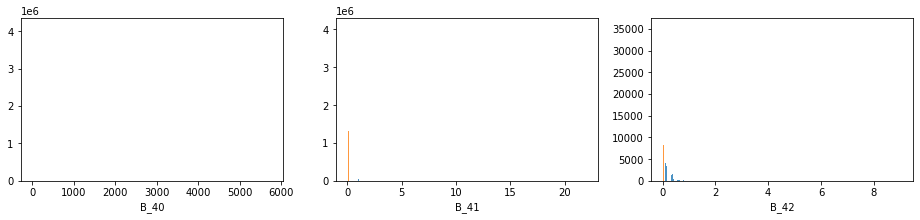

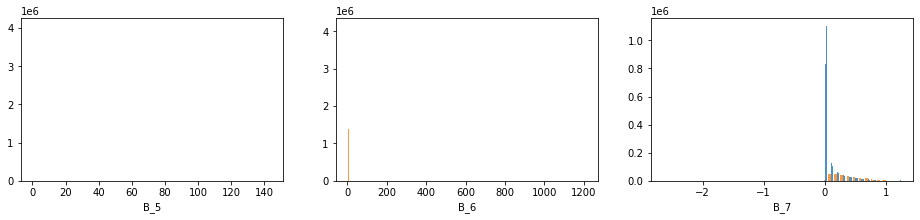

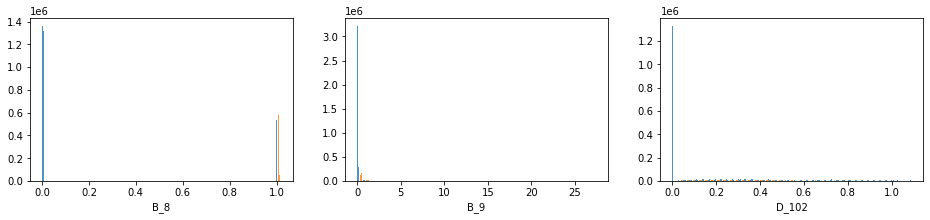

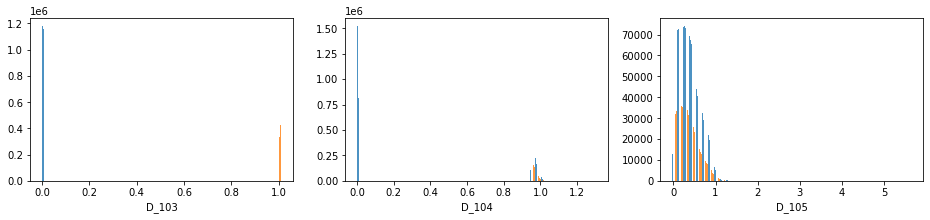

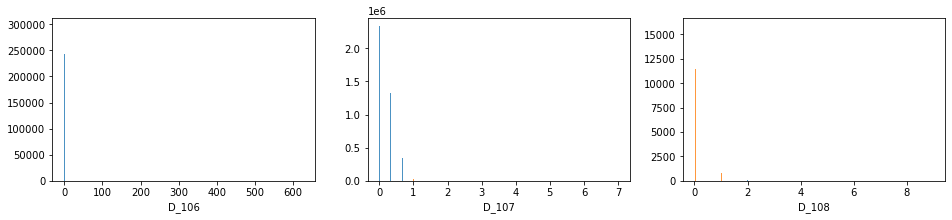

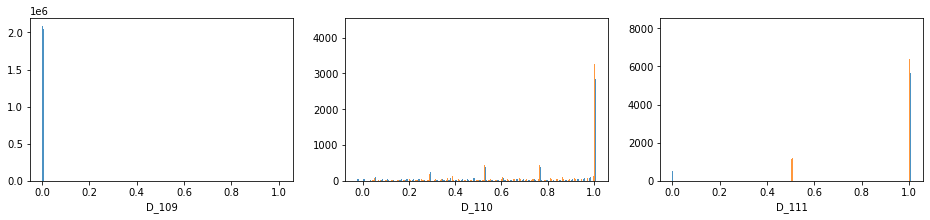

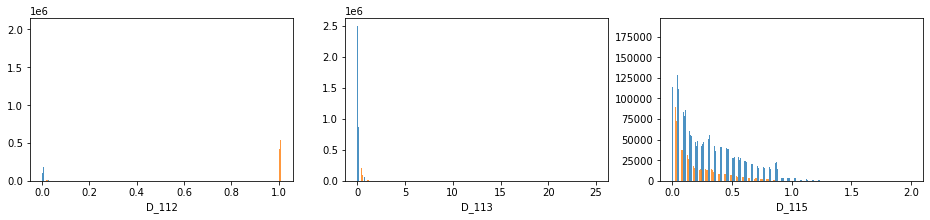

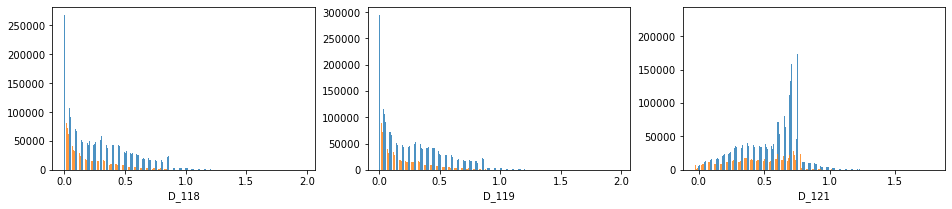

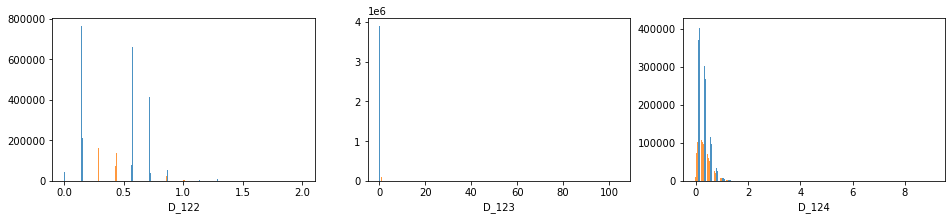

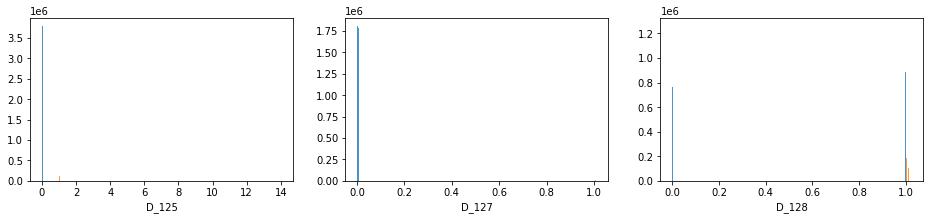

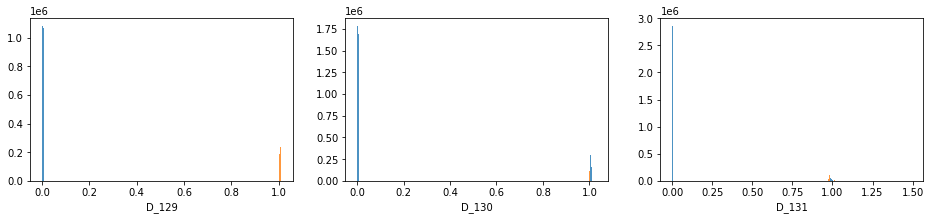

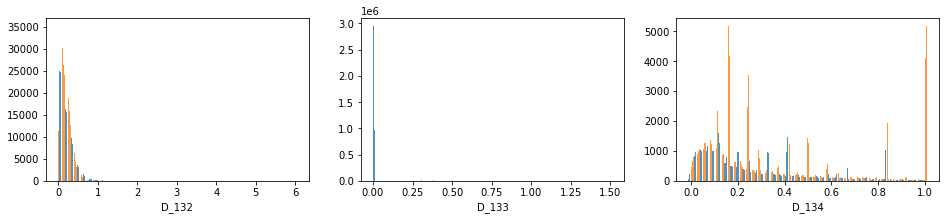

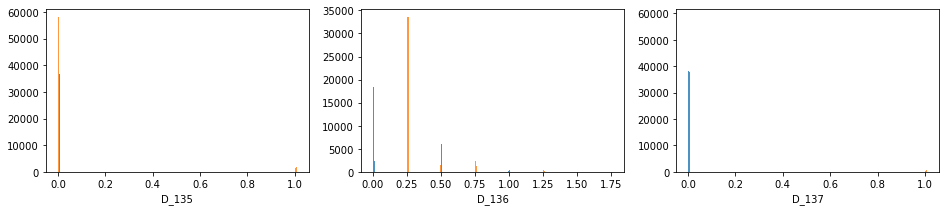

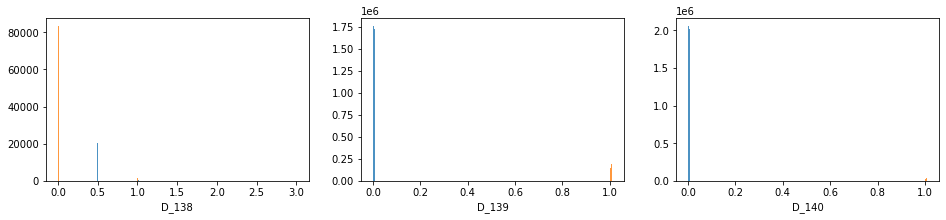

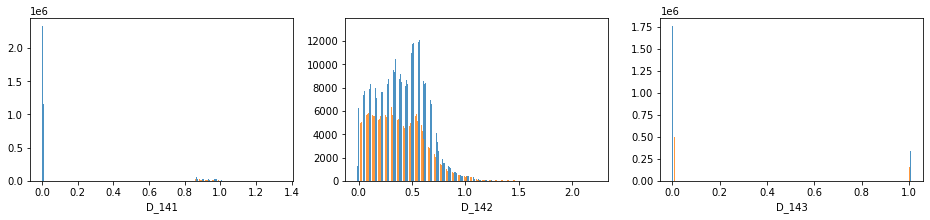

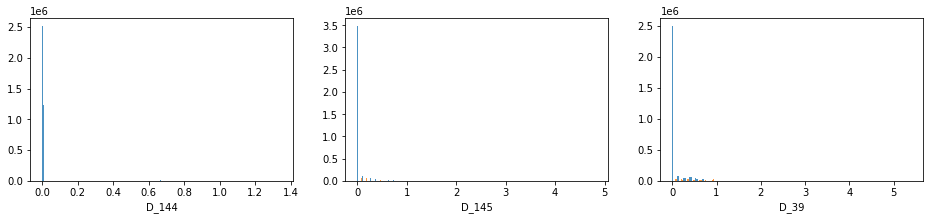

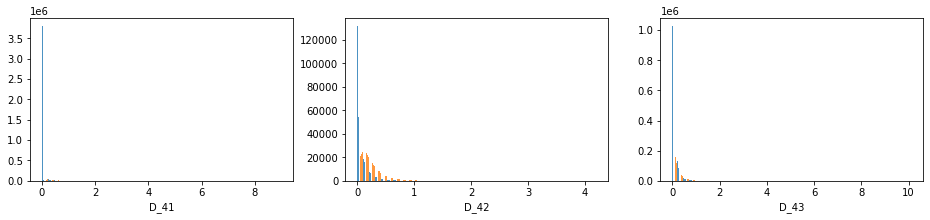

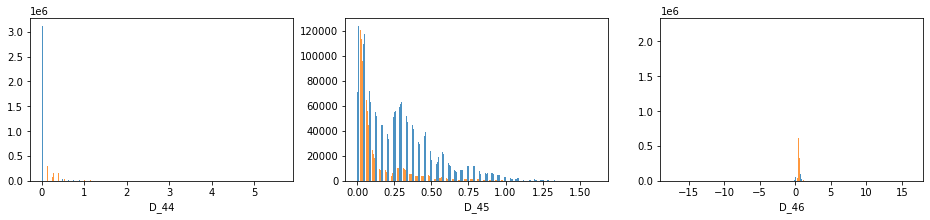

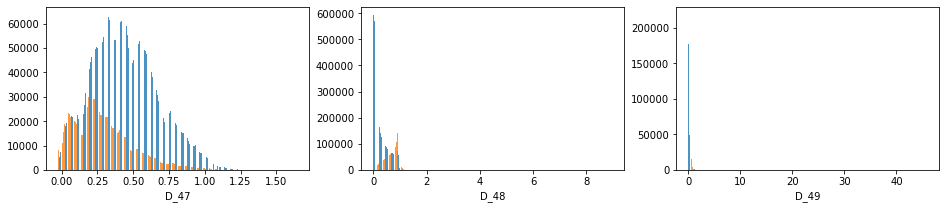

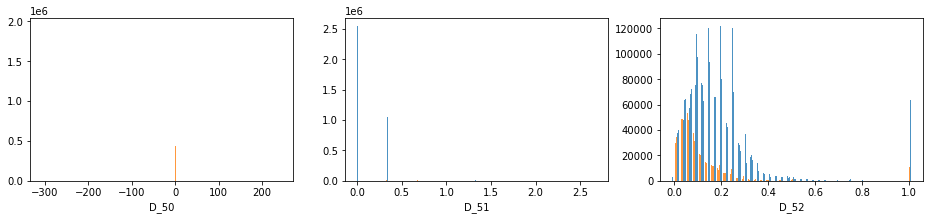

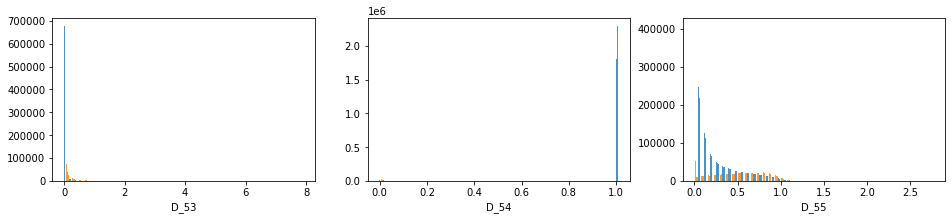

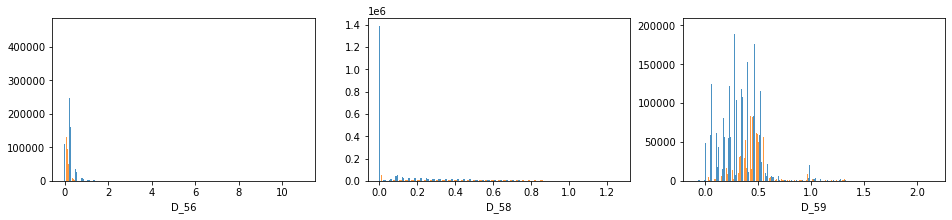

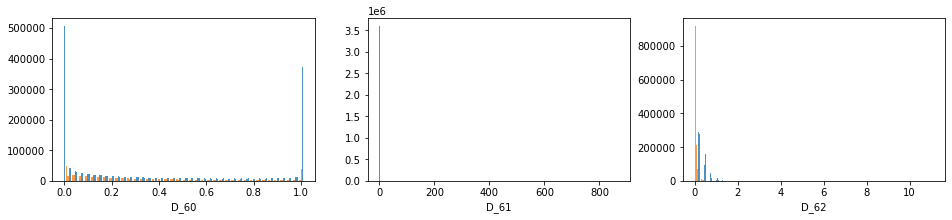

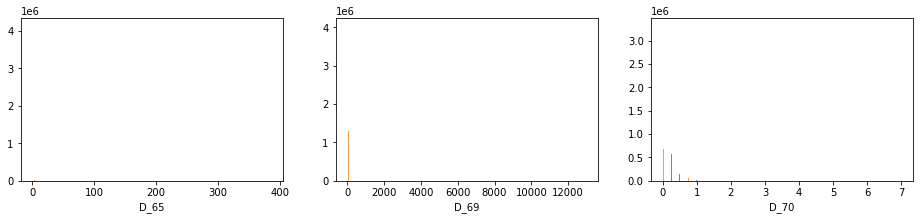

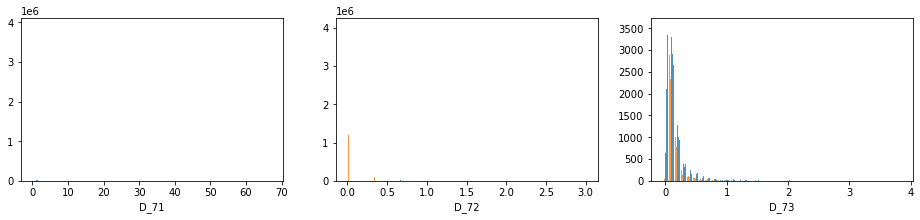

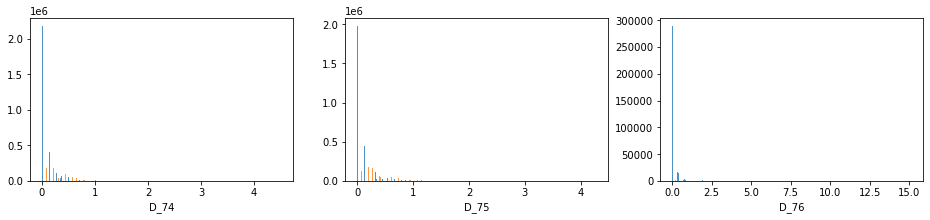

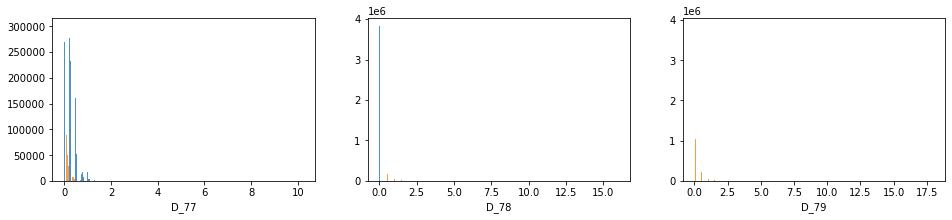

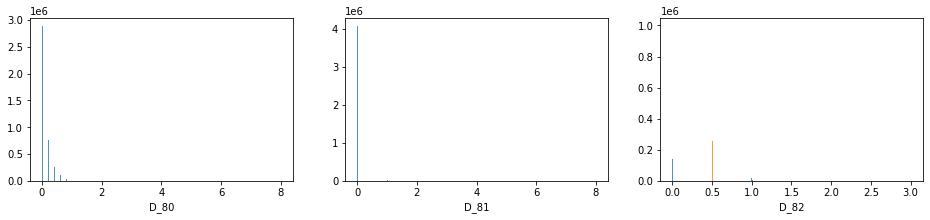

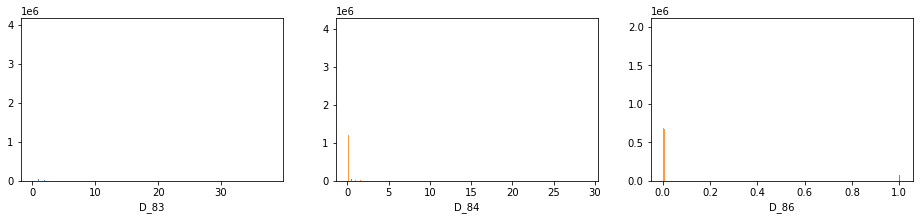

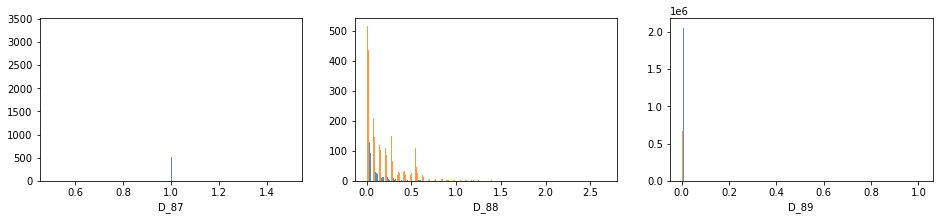

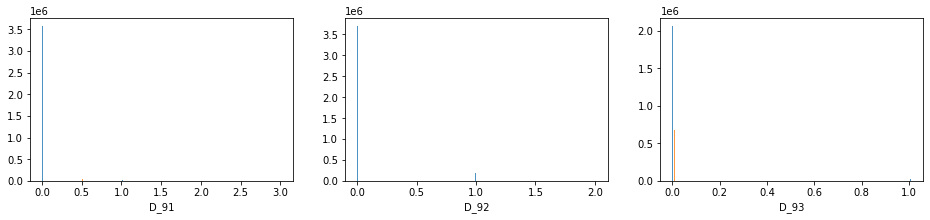

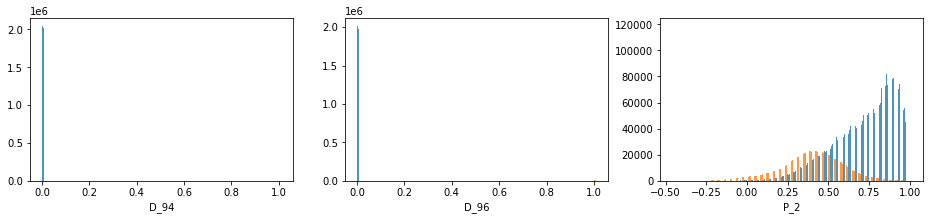

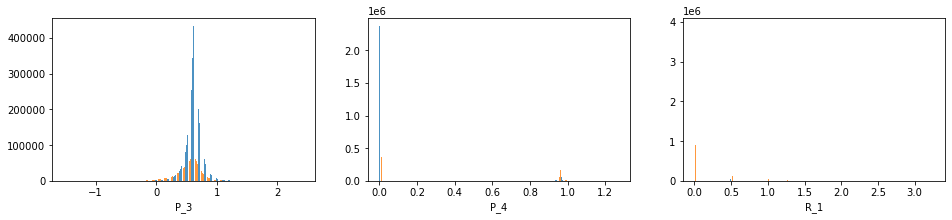

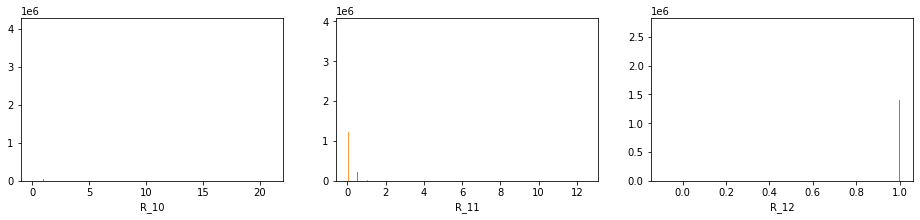

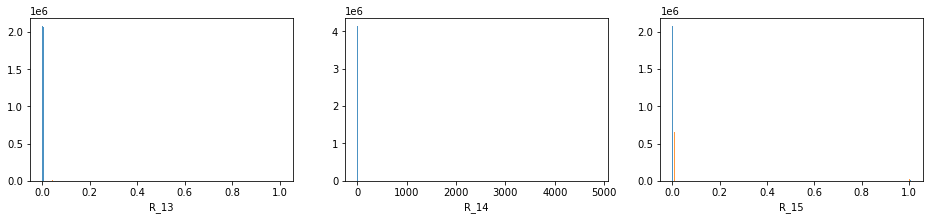

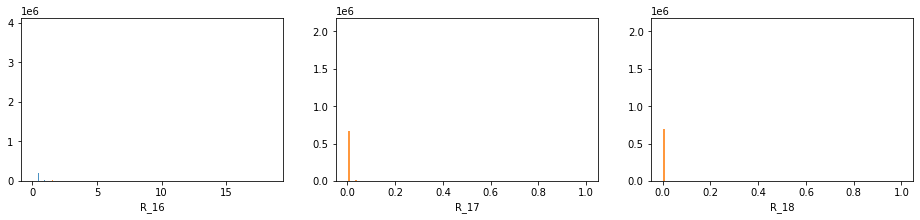

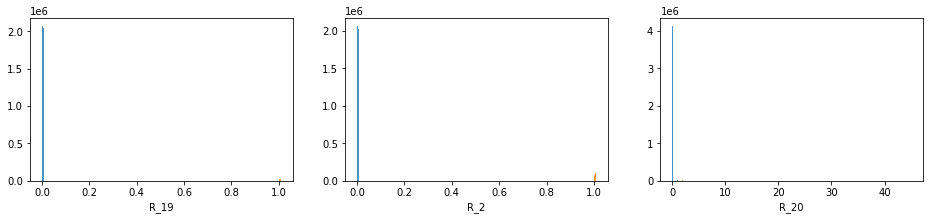

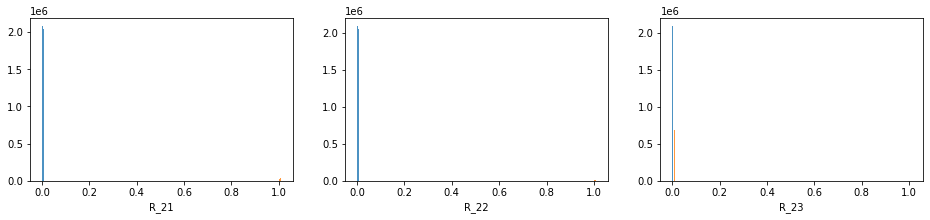

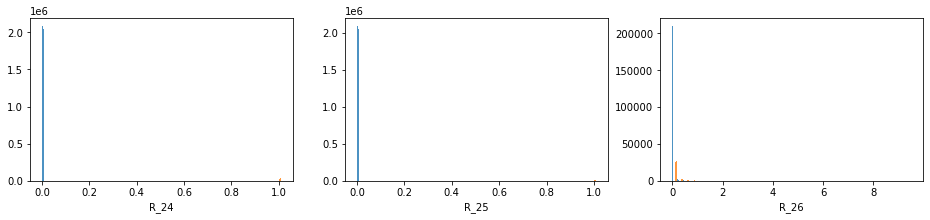

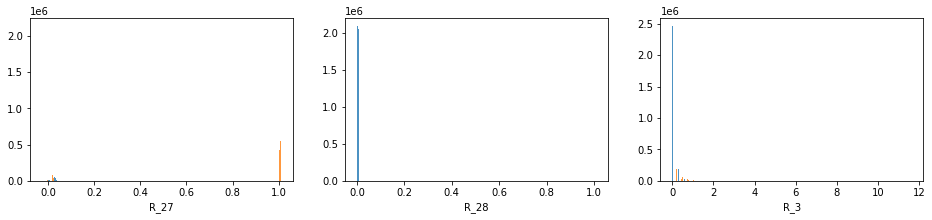

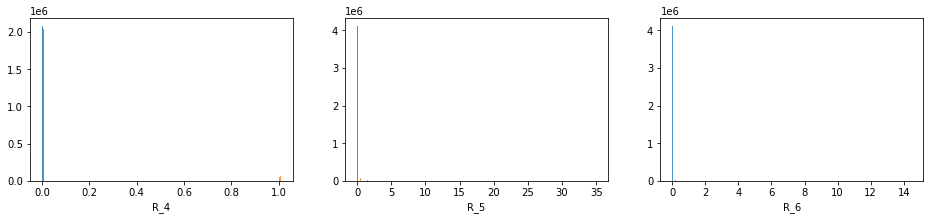

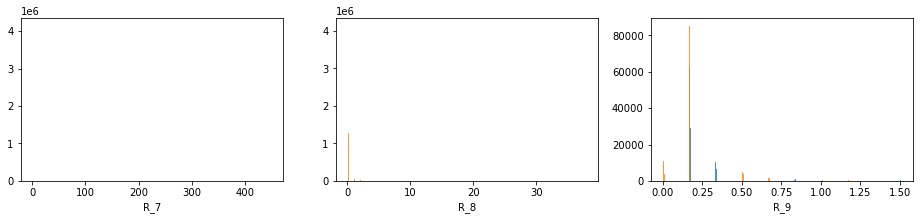

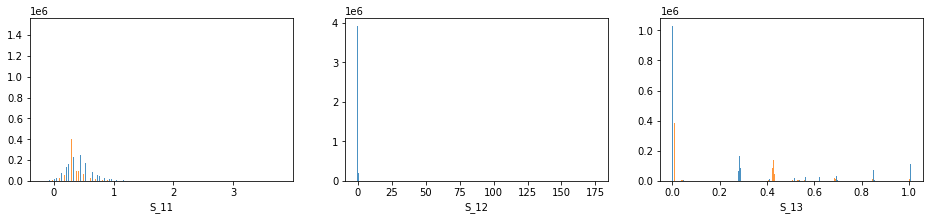

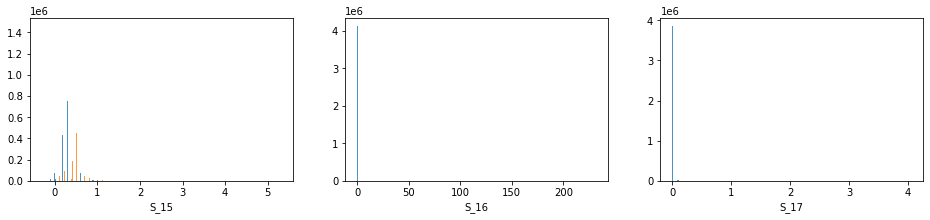

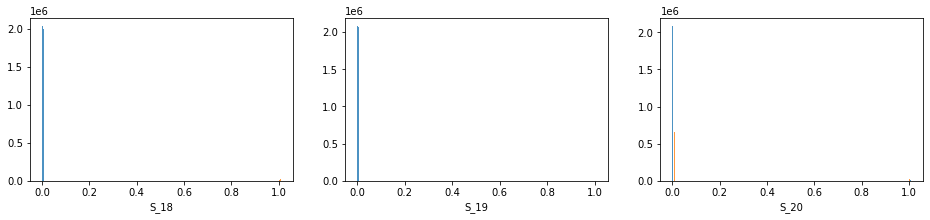

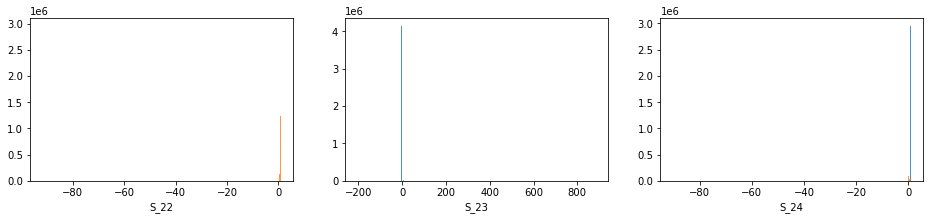

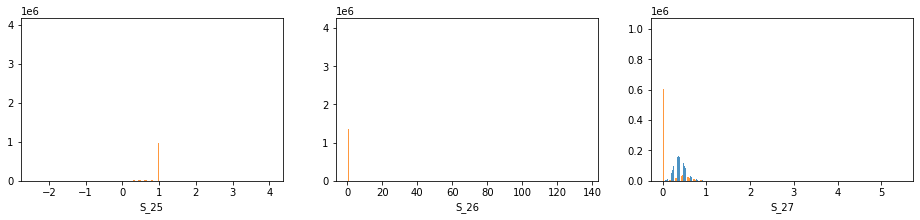

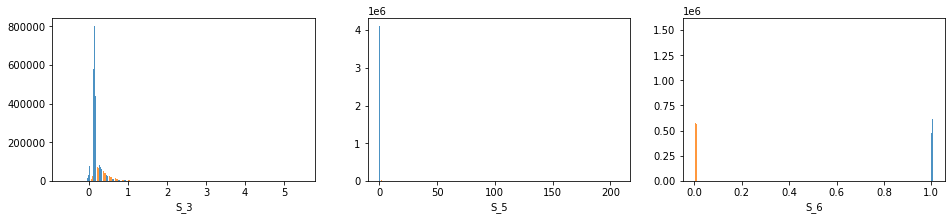

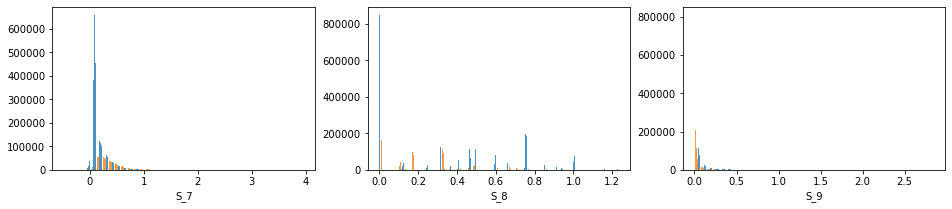

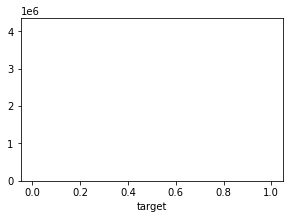

In [22]:
# print(cont_features)
ncols = 3
for i, f in enumerate(sorted(continous_variables[2:])):
    if i % ncols == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(16, 3))
        if i == 0: plt.suptitle('Continuous features', fontsize=20, y=1.02)
    plt.subplot(1, ncols, i % ncols + 1)
    plt.hist([plot_df.loc[plot_df['target'] == 0][f], plot_df.loc[plot_df['target'] == 1][f]], bins = 200,
         histtype='bar',
         stacked=False,  
         fill=True,
         label=['Paid', 'Default'],
         alpha=0.8)
    plt.xlabel(f)
plt.show()

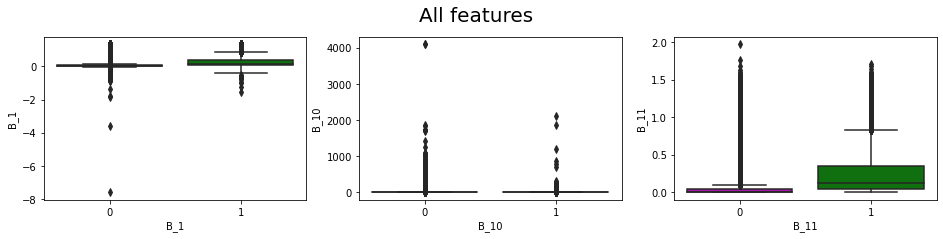

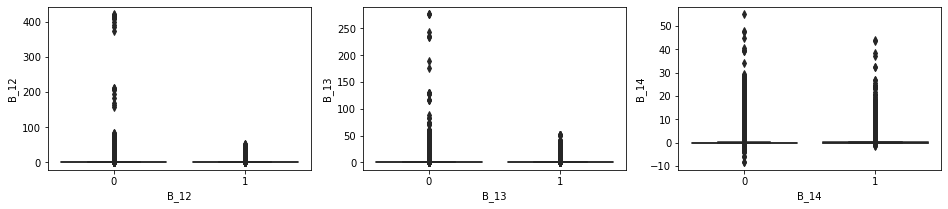

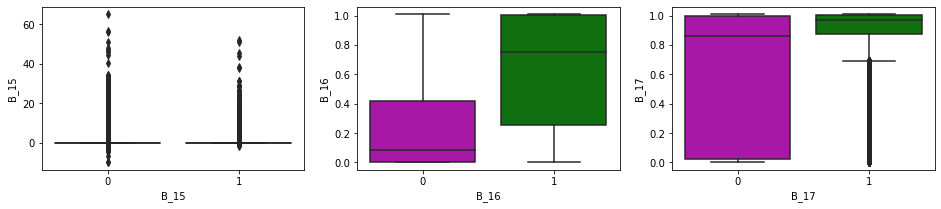

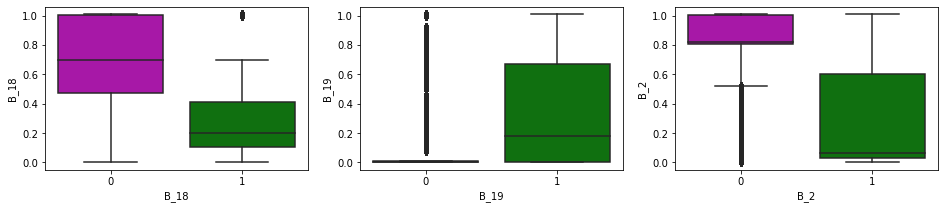

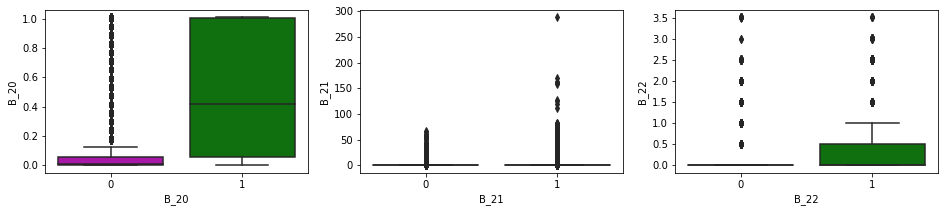

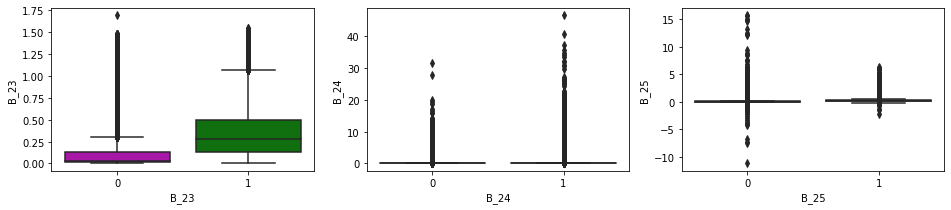

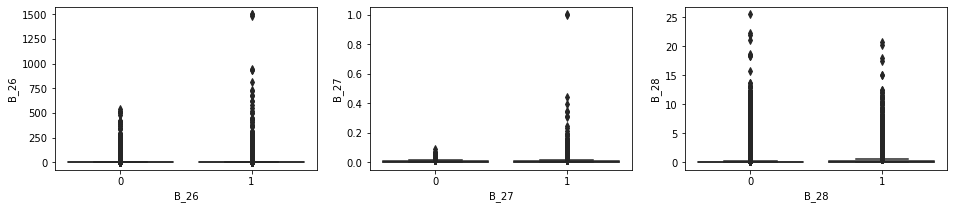

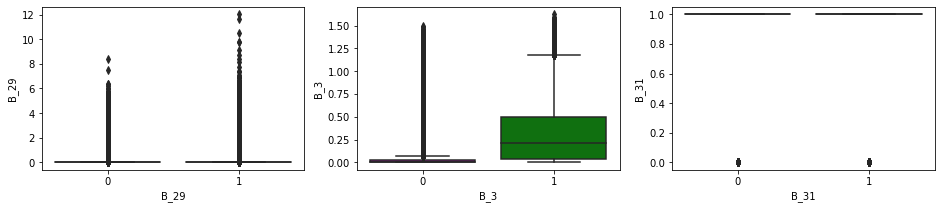

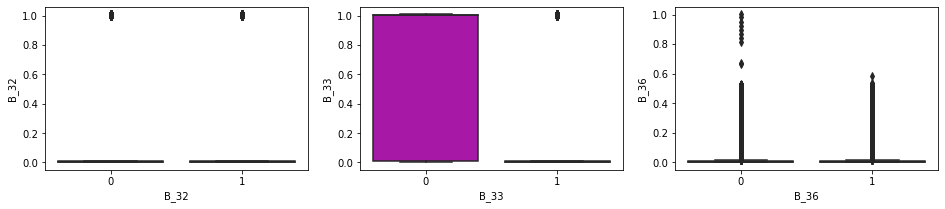

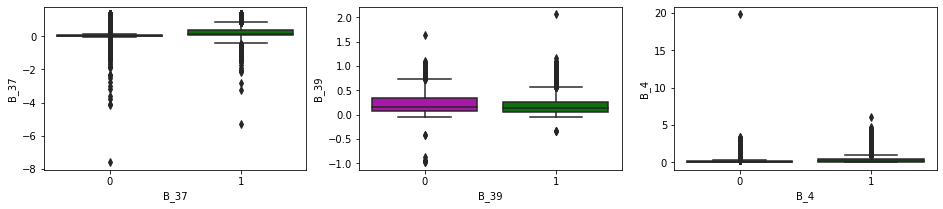

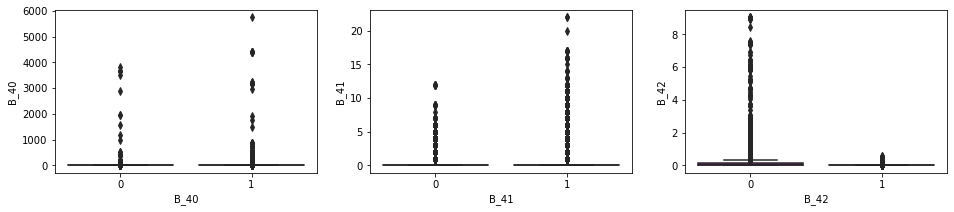

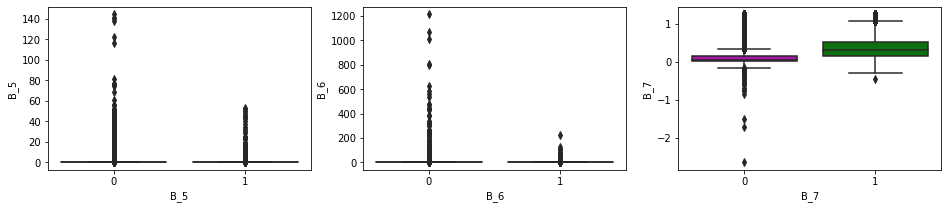

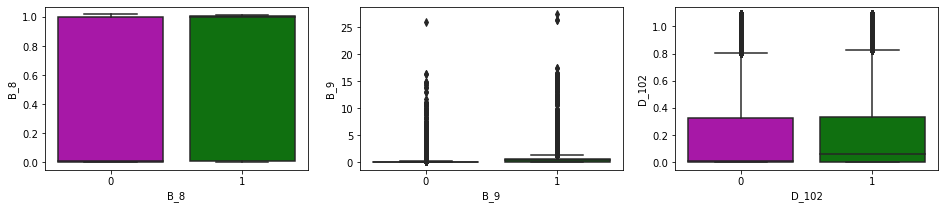

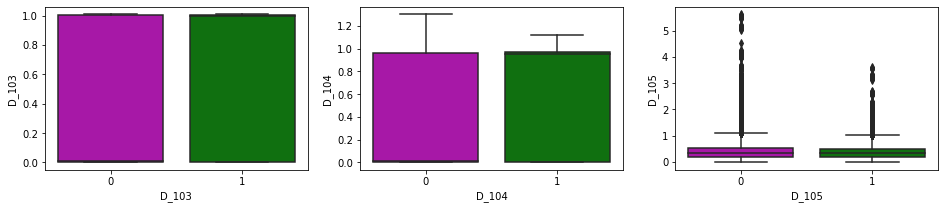

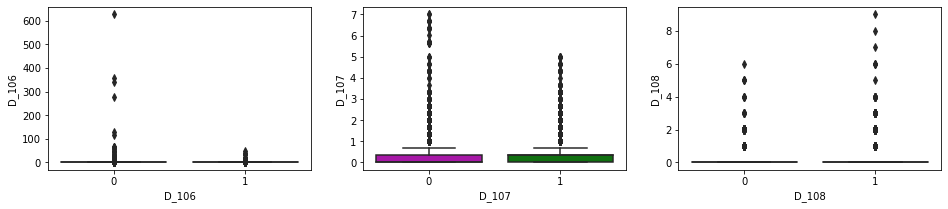

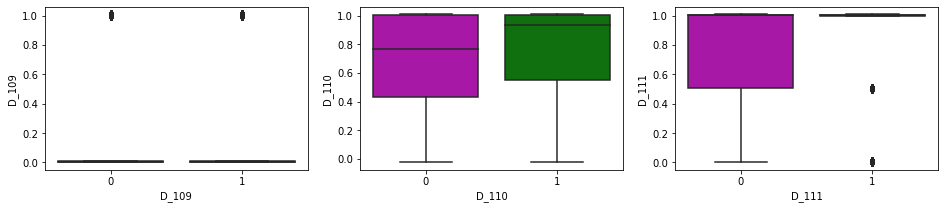

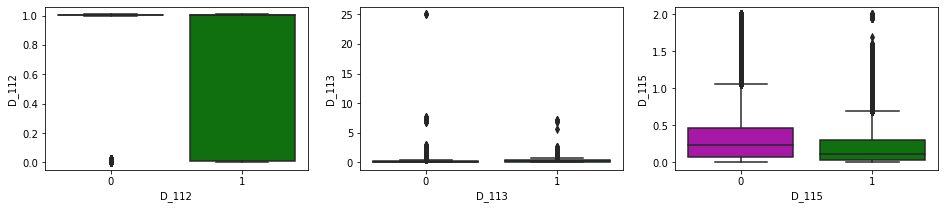

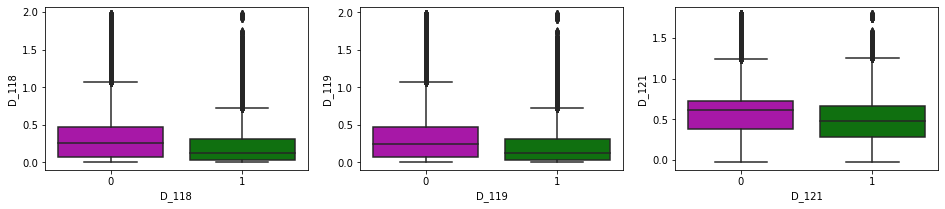

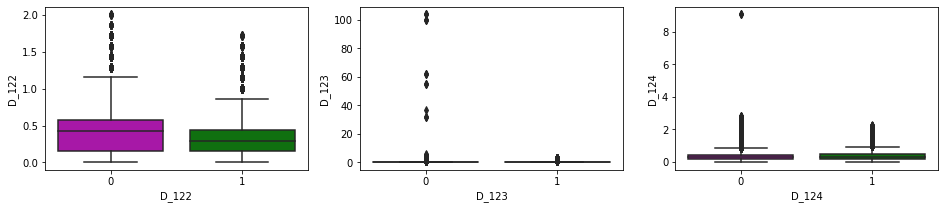

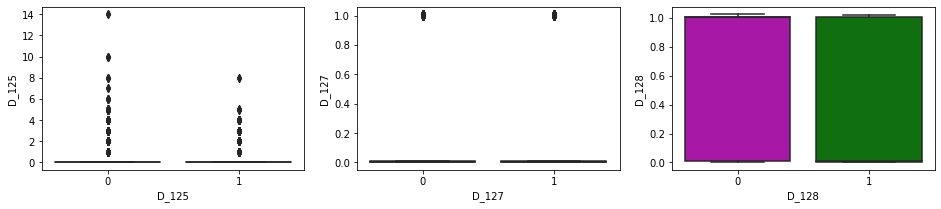

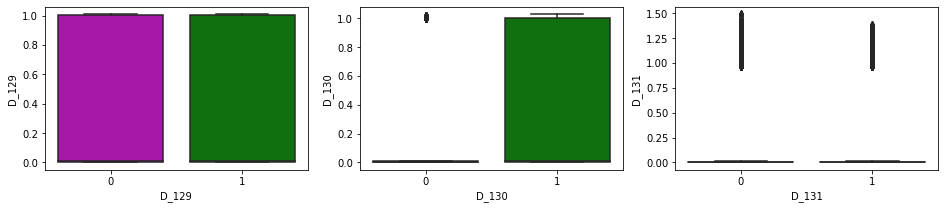

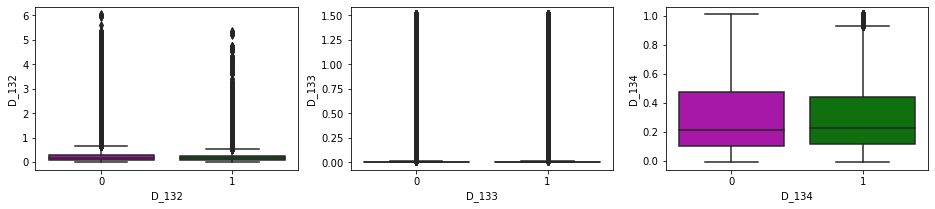

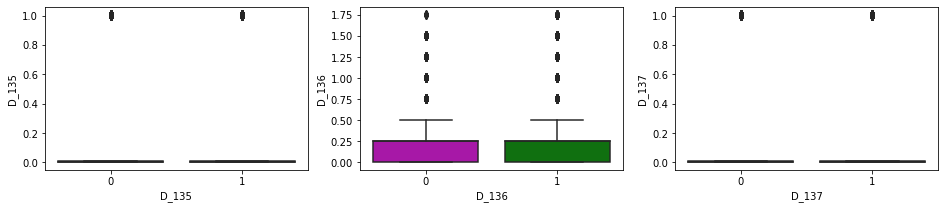

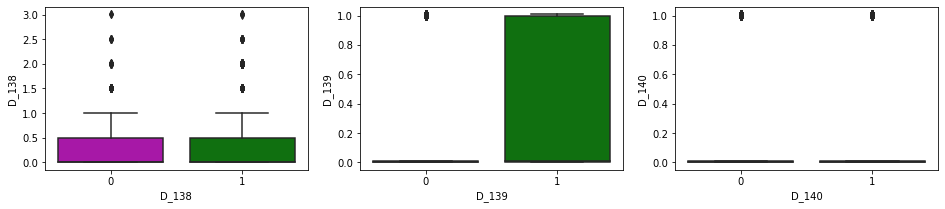

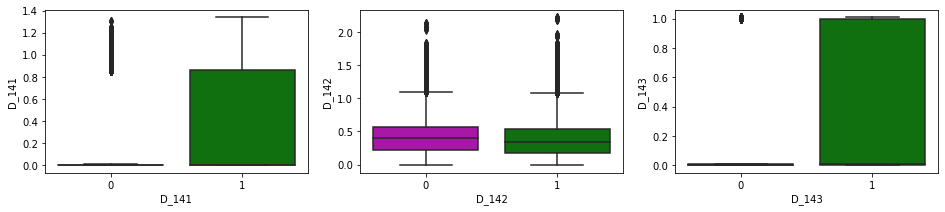

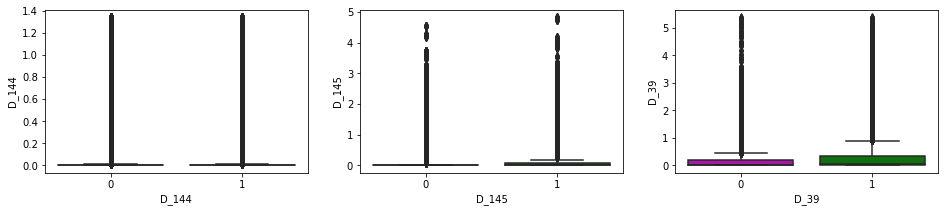

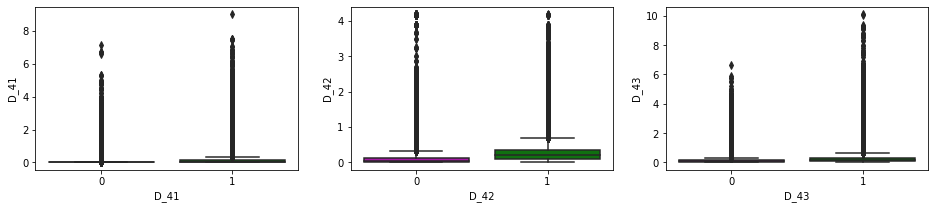

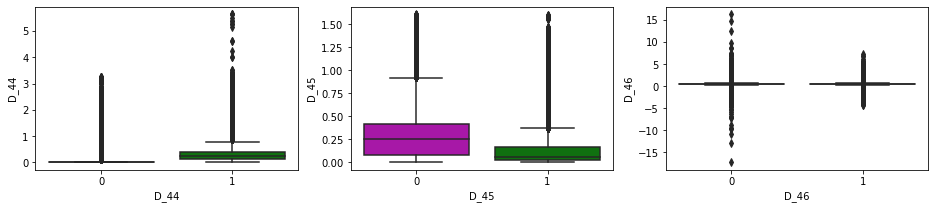

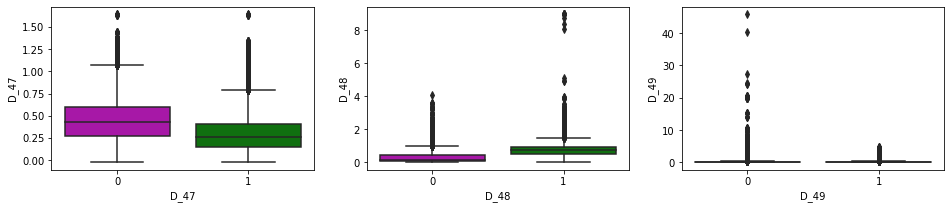

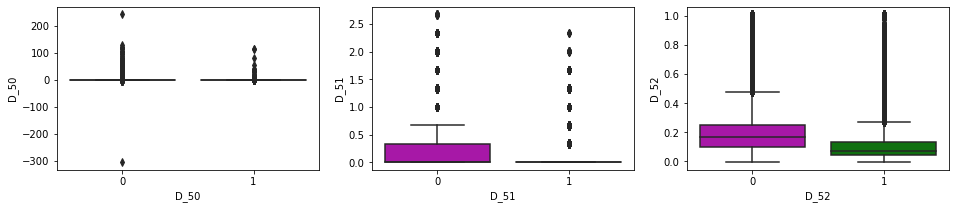

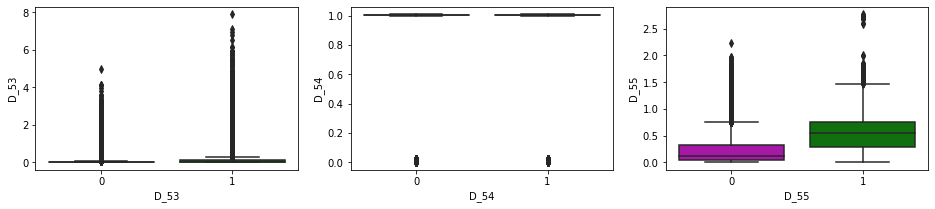

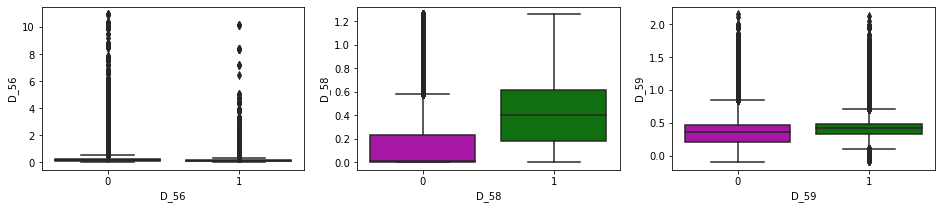

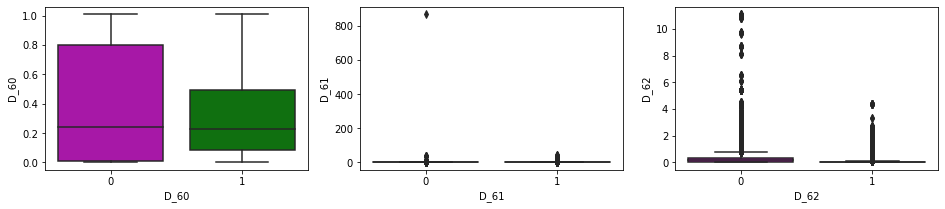

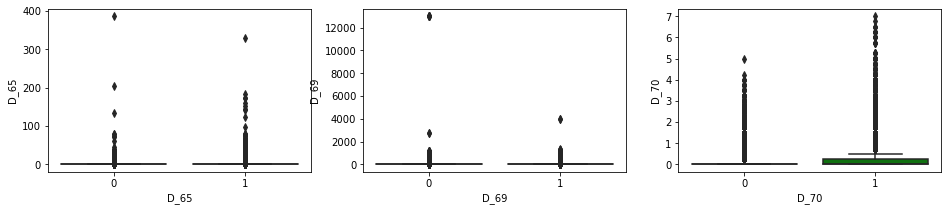

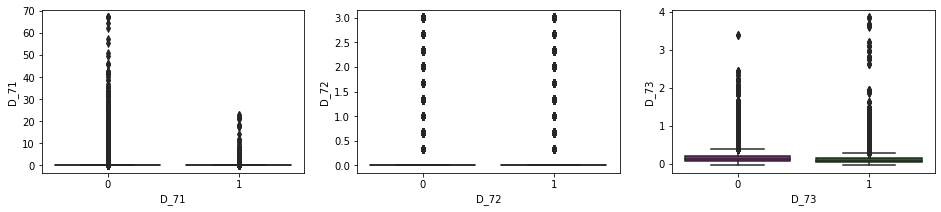

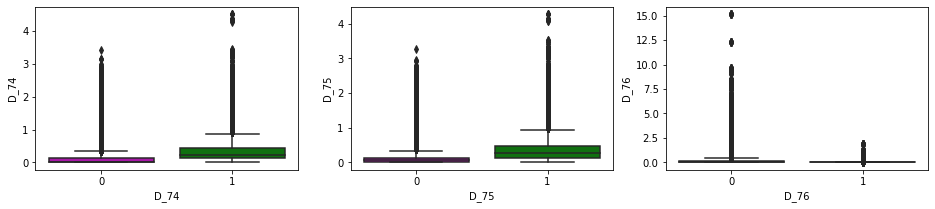

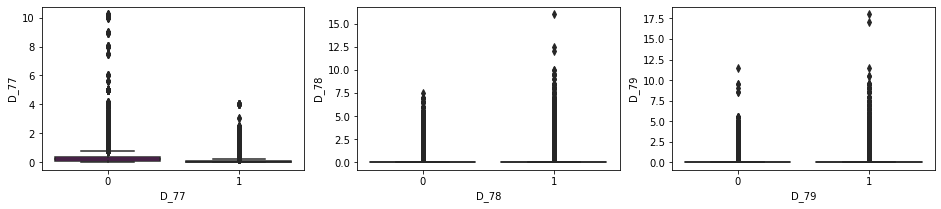

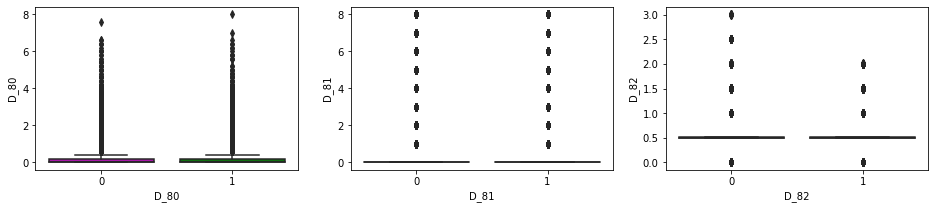

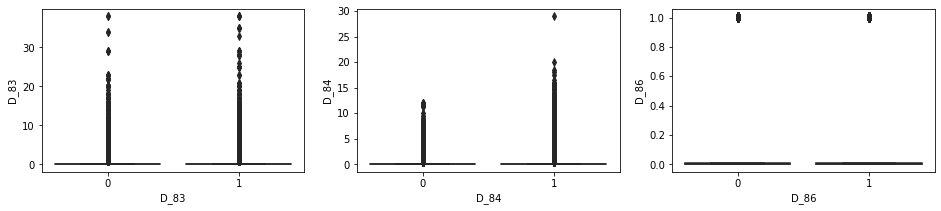

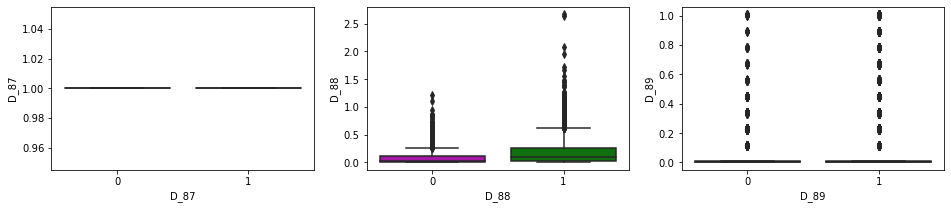

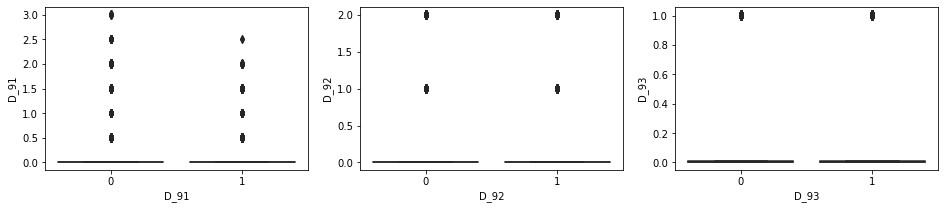

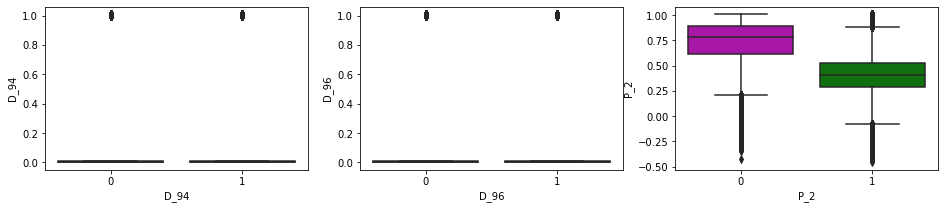

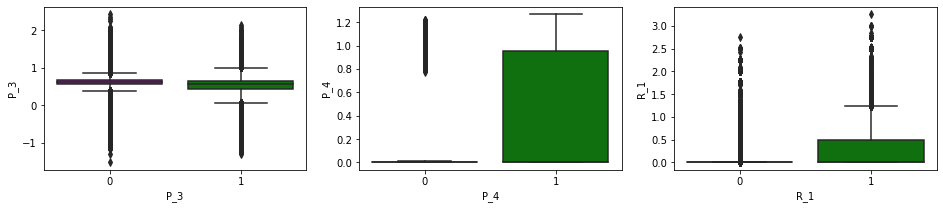

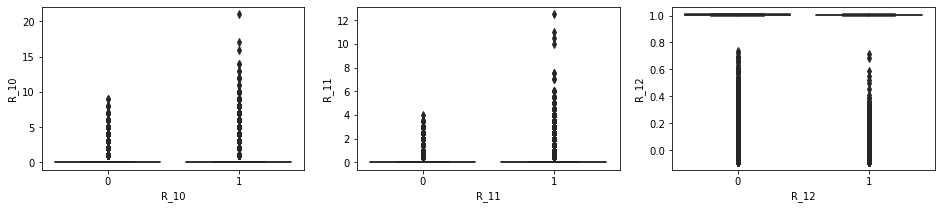

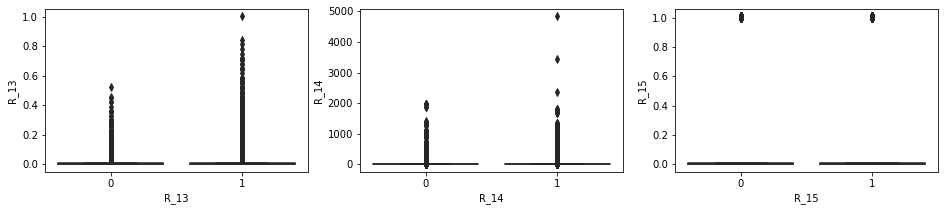

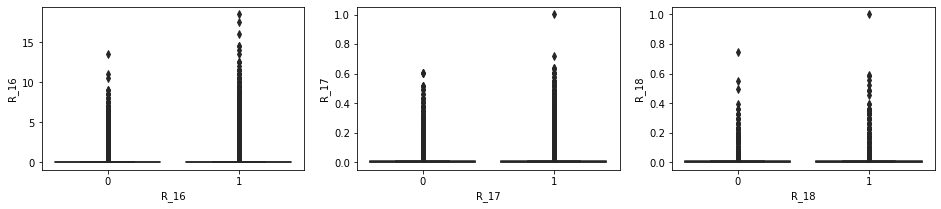

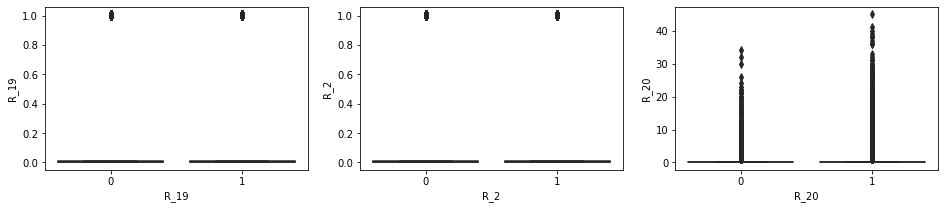

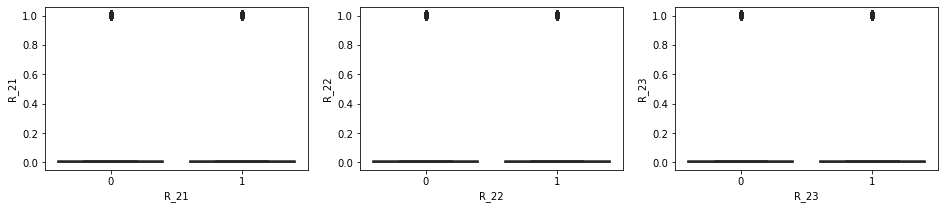

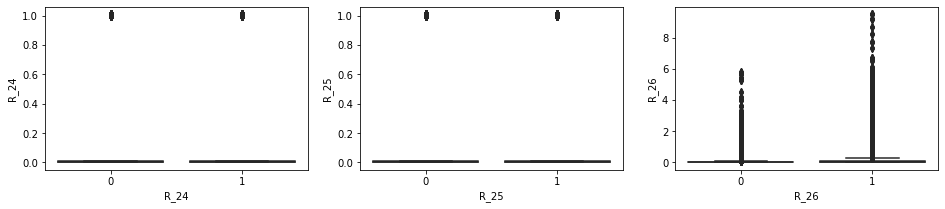

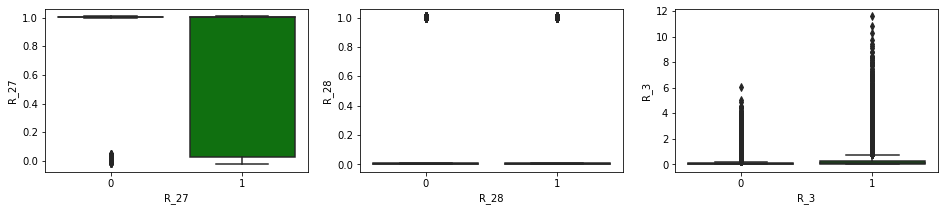

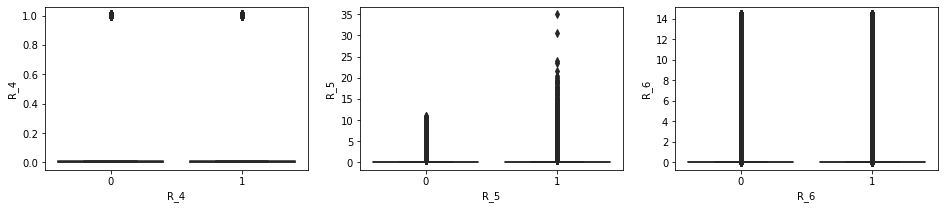

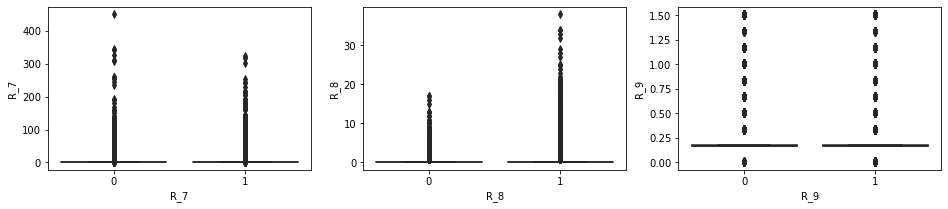

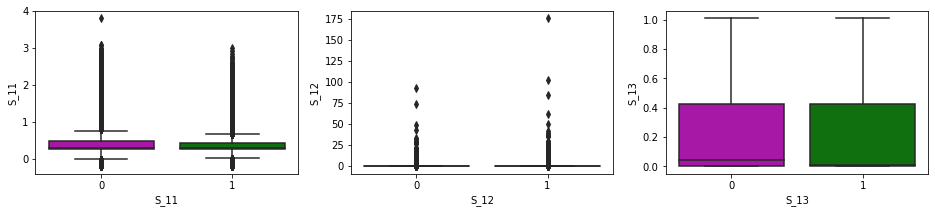

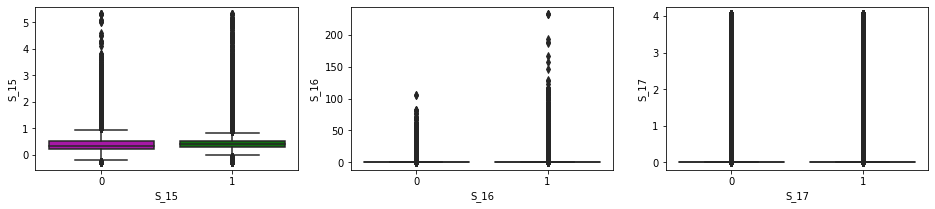

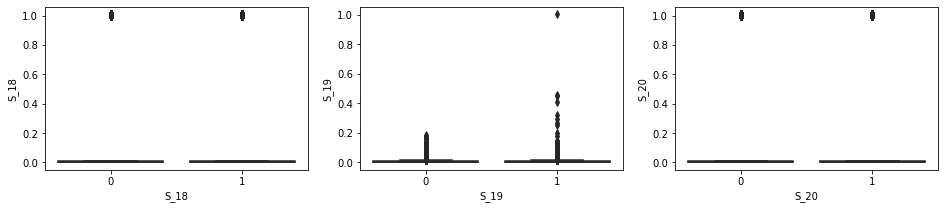

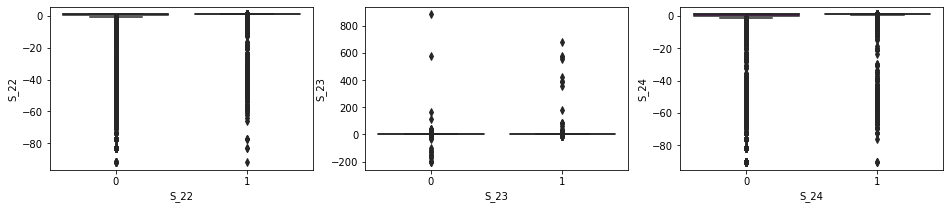

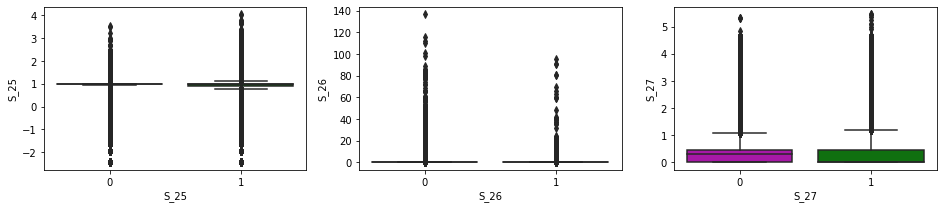

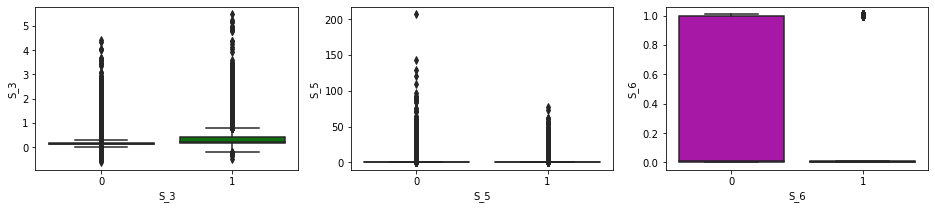

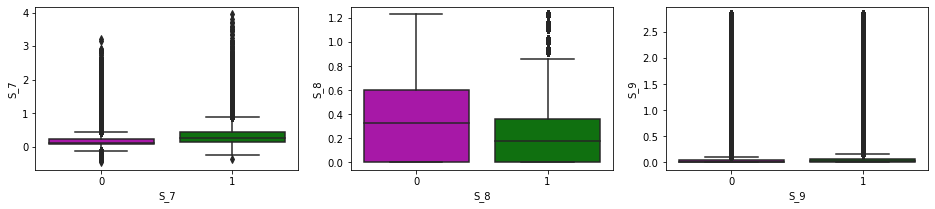

In [23]:
# print(cont_features)
ncols = 3
for i, f in enumerate(sorted(continous_variables[2:-1])):
    if i % ncols == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(16, 3))
        if i == 0: plt.suptitle('All features', fontsize=20, y=1.02)
    plt.subplot(1, ncols, i % ncols + 1)
    sns.boxplot(y=f, #y="total_bill",
            x="target", palette=["m", "g"],
            data=plot_df)
    plt.xlabel(f)
plt.show()

In [10]:
 
gc.collect()

4210

# Decision making - filling missing values, dropping columns, handling outliers

## Filling missing values & dropping columns

- 'D_87': 0.000698731670948545 <b> DROP </b>
- 'D_88': 0.0010854294831500813, <b> DROP </b>
- 'D_108': 0.005231538704763, <b> DROP </b>

- 'D_110': 0.005664698105433818, <b> DROP </b>
- 'D_111': 0.005664698105433818, <b> DROP </b>

- 'B_39': 0.006080140635793393, <b> DROP </b>
- 'D_73': 0.01009789293984526, <b> DROP </b>
- 'B_42': 0.012922106694970271,<b> DROP </b>

- 'D_134': 0.03519854012988635, <b> DROP </b>
- 'D_135': 0.03519854012988635, <b> DROP </b>
- 'D_136': 0.03519854012988635, <b> DROP </b>
- 'D_137': 0.03519854012988635, <b> DROP </b>
- 'D_138': 0.03519854012988635, <b> DROP </b>

- 'R_9': 0.05650108805085682, <b> DROP </b>
- 'B_29': 0.06895405925136099, <b> DROP </b>
- 'D_106': 0.09786744924613813, <b> DROP </b>
- 'D_132': 0.09808945247820147, <b> DROP </b>
- 'D_49': 0.09862403192218461, <b> DROP </b>
- 'R_26': 0.11015283331624921, <b> DROP </b>
- 'D_76': 0.11253774100141174, <b> DROP </b>
- 'D_66': 0.11269267322443967, <b> DROP </b>
- 'D_42': 0.1430572195252204, <b> DROP </b>
- 'D_142': 0.17073422507042005, <b> DROP </b>
- 'D_53': 0.26157078856885835, <b> DROP </b>
- 'D_82': 0.2662659399857289, <b> DROP </b>
- 'D_50': 0.4319027683694568, hard decision, prob some smarter inputation
- 'B_17': 0.4327712565834896, target dependend inputation???! the outlier occur only for defaults, meaning that this feature has standard distribution when no default occurs
- 'D_105': 0.453772436924778, some form of target dependend inputation
- 'D_56': 0.4592841914354841, np.nanmedian(df['D_56']) groupped
- 'S_9': 0.4696431370358338, np.nanmedian(df['D_56']) groupped
- 'D_77': 0.5455239502257183, median?
- 'D_43': 0.7001878892174946, median?
- 'S_27': 0.7467328192909961, median?
- 'D_46': 0.7809437342932262, mean
- 'S_3': 0.8155015745416528, mean
- 'S_7': 0.8155015745416528, mean
- 'D_62': 0.862936325387317, mean
- 'D_48': 0.8700657386280742, mean
- 'D_61': 0.891881533434898, mean
- 'P_3': 0.9454949524094131, mean groupped

- 'D_44': 0.9504074066641827,  mean
- 'D_78': 0.9504074066641827, mean

- 'D_64': 0.9606898804671685, mean
- 'D_68': 0.9608596370102528, mean

- 'D_69': 0.964842317142464, mean
- 'D_83': 0.964842317142464, mean

- 'D_55': 0.9665905022027674, mean

all mean ---> this group is going to get killed due to high correlations
- 'D_113': 0.9680525055722269,
- 'D_114': 0.9680525055722269,
- 'D_115': 0.9680525055722269,
- 'D_116': 0.9680525055722269,
- 'D_117': 0.9680525055722269,
- 'D_118': 0.9680525055722269,
- 'D_119': 0.9680525055722269,
- 'D_120': 0.9680525055722269,
- 'D_121': 0.9680525055722269,
- 'D_122': 0.9680525055722269,
- 'D_123': 0.9680525055722269,
- 'D_124': 0.9680525055722269,
- 'D_125': 0.9680525055722269,

- 'D_91': 0.9715778011953825,
- 'R_27': 0.9767325065339999,
- 'D_126': 0.9788814905889973,
- 'D_59': 0.9807057858778827,

all mean ---> this group is going to get killed due to high correlations
- 'D_103': 0.9816417066697327,
- 'D_104': 0.9816417066697327,
- 'D_107': 0.9816417066697327,
- 'D_128': 0.9816417066697327,
- 'D_129': 0.9816417066697327,
- 'D_130': 0.9816417066697327,
- 'D_131': 0.9816417066697327,
- 'D_139': 0.9816417066697327,
- 'D_141': 0.9816417066697327,
- 'D_143': 0.9816417066697327,
- 'D_145': 0.9816417066697327,

- 'D_70': 0.9828404879659967,
- 'D_79': 0.9862714141370863,
- 'B_13': 0.9910477377454848,
- 'P_2': 0.9916866297830352,
- 'D_133': 0.9922776139569889,
- 'D_144': 0.9926371941105507,
- 'D_102': 0.9926502105866978,
- 'D_140': 0.9926543686276892,


- 'D_52': 0.9946554710509051,
- 'D_84': 0.9946554710509051,
- 'D_89': 0.9946554710509051,

all mean ---> this group is treated this way just for 
- 'D_81': 0.9953561913501539,
- 'D_72': 0.9957139636598065,
- 'B_8': 0.9959742931827472,
- 'D_74': 0.9960637814562581,
- 'D_80': 0.9960637814562581,
- 'S_22': 0.9965607577469275,
- 'S_24': 0.9966386758194188,
- 'S_25': 0.9976774629297087,
- 'B_15': 0.9987484296615843,
- 'B_25': 0.9987484296615843,
- 'D_112': 0.9995209213640327,
- 'D_45': 0.999635357883492,


1st completeness group ----> basic input mean, new feature to be added
- 'B_2': 0.999635538667883,
- 'D_41': 0.999635538667883,
- 'B_3': 0.999635538667883,
- 'D_54': 0.999635538667883,
- 'B_16': 0.999635538667883,
- 'B_19': 0.999635538667883,
- 'B_20': 0.999635538667883,
- 'B_22': 0.999635538667883,
- 'B_26': 0.999635538667883,
- 'B_27': 0.999635538667883,
- 'B_30': 0.999635538667883,
- 'B_33': 0.999635538667883,
- 'B_38': 0.999635538667883,

- 'D_109': 0.9997112873276831, np.nanmean(df['D_109'].astype('float64'))
- 'B_41': 0.9998752587702576, np.nanmean(df['B_41'].astype('float64'))
- 'S_26': 0.9998853826961497, np.nanmean(df['S_26'].astype('float64'))
- 'S_23': 0.9999195509460357, np.nanmean(df['S_23'].astype('float64'))
- 'B_6': 0.9999578772369131, np.nanmean(df['B_6'].astype('float64'))
- 'R_20': 0.9999864411706801, np.nanmean(df['R_20'].astype('float64'))

- 'R_12': 0.9999898760741078, np.nanmean(df['R_12'].astype('float64'))
- 'B_37': 0.9999898760741078, np.nanmean(df['B_37'].astype('float64'))

- 'B_40': 0.9999904184272806, np.nanmean(df['B_40'].astype('float64'))

- 'R_7': 0.9999998192156091, np.nanmean(df['R_7'].astype('float64'))
- 'R_14': 0.9999998192156091, <b> np.nanmean(df['R_14'].astype('float64')) </b>

Additional:
- 'X_1' 1st group completeness binary flag

In [135]:
cors['D_56'].sort_values()

D_42     -0.204390
D_88     -0.195185
B_7      -0.165999
D_58     -0.165916
S_3      -0.163976
D_75     -0.162939
D_74     -0.157646
S_7      -0.157297
B_23     -0.155160
D_48     -0.153697
D_61     -0.151782
S_15     -0.151509
target   -0.146568
B_19     -0.133175
B_16     -0.132530
B_8      -0.126948
D_130    -0.122503
B_20     -0.121700
D_55     -0.116939
B_38     -0.116686
D_44     -0.116558
B_3      -0.115539
B_9      -0.115318
B_30     -0.112192
D_59     -0.110692
B_4      -0.107293
B_17     -0.105581
B_1      -0.105117
B_37     -0.104488
D_114    -0.101872
D_70     -0.099386
B_22     -0.096754
B_11     -0.094253
D_131    -0.094009
D_79     -0.083074
P_4      -0.080578
D_139    -0.073893
D_143    -0.073857
D_141    -0.072408
D_136    -0.069891
D_133    -0.068434
D_134    -0.063916
D_145    -0.063214
D_104    -0.061341
R_1      -0.061246
D_103    -0.061146
D_120    -0.058248
R_26     -0.056722
D_53     -0.052682
D_78     -0.050706
D_43     -0.050082
R_2      -0.049619
B_32     -0.

In [136]:
np.nanmean(df['D_56'].astype('float64'))

0.203709443321177

In [137]:
np.nanmedian(df['D_56'])

0.1494

<AxesSubplot:>

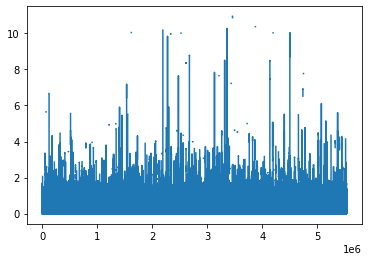

In [139]:
df['D_56'].plot()

### Suspicious group of similar completeness

In [113]:
cors.loc[['B_2',
 'D_41',
 'B_3',
 'D_54',
 'B_16',
 'B_19',
 'B_20',
 'B_22',
 'B_26',
 'B_27',
 'B_30',
 'B_33',
 'B_38', 'target']][['B_2',
 'D_41',
 'B_3',
 'D_54',
 'B_16',
 'B_19',
 'B_20',
 'B_22',
 'B_26',
 'B_27',
 'B_30',
 'B_33',
 'B_38']].style.background_gradient(cmap='coolwarm')

Some correlations are very high, so the will be transformed/ removed later on, but some are not, which leads me to an idea for a feature based on completeness.